# Phase 2: Analysis & evaluation

In part one of the project I constructed a data processing pipeline that took in the raw text of 3 books, and produced 'ready-to-use' outputs saved to a database:

![Main pipeline components](pipeline.png)

The objective now is to use this dataset to:

__1. Identify key characters in novels (information extraction)__

And then  demonstrate how we could use the information extracted (about the books and their characters) to: 

__2. Present potentially useful contextual and quantitative information to aid the reading experience (visualization)__

The outputs, if successful, should potentially _assist_ a human literary analyst with contextual information; as well as providing a more quantitative perspective to supplement traditional qualitative methods.

The three initial novels selected for the project were obtained (with permission) from Project Gutenberg at the following locations:

* __Great Expectations__: https://www.gutenberg.org/files/1400/1400-0.txt (Dickens, 1998)<br>
* __Alice In Wonderland__: https://www.gutenberg.org/ebooks/19033.txt.utf-8 (Carroll, 2008)<br>
* __Little Women__: https://www.gutenberg.org/ebooks/514.txt.utf-8 (Alcott, 1996)<br>

I prepared a fourth book for the database which will be reserved for the evaluation phase - a test case we can use to assess whether the proposed methods can be applied to other books:

* __Jane Eyre__: https://www.gutenberg.org/cache/epub/1260/pg1260.txt (Bronte, 1998)<br>

#### Library imports

In [1]:
# Standard utilities
import re
import pprint
import datetime
import itertools
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
from collections import defaultdict

# NLP tasks
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import wordnet as wn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Storage
from sqlalchemy import create_engine

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles
from wordcloud import WordCloud

# Data checking
import pywikibot
import requests

#### Settings

In [2]:
# General settings
warnings.filterwarnings('ignore')

# Pandas settings
pd.set_option('display.max_colwidth', 500)
tqdm_notebook.pandas()

# Pandas highlight columns gold
def highlight_column(column):
    '''Highlight specified columns in df - used as argument in df.style.apply() function'''
    return ['background-color: gold' for item in column.values]

# Visualization settings
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_theme()
authors = ['dickens', 'carroll', 'alcott']
all_authors = ['dickens', 'carroll', 'alcott', 'bronte']
author_colors = {'dickens': '#ED230D', 'carroll': '#00A1FE', 'alcott': '#1EB100', 'bronte': '#FF1393'}
author_colormaps = {'dickens': 'YlOrRd', 'carroll': 'GnBu', 'alcott': 'YlGn', 'bronte': 'PuRd'}

# SQL settings
%load_ext sql
%sql sqlite:///book_store.db
# Set the style to the old default as advised by
# https://stackoverflow.com/questions/79153112/keyerror-default-when-attempting-to-create-a-table-using-magic-line-sql-in-j
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

engine = create_engine('sqlite:///book_store.db', echo=False)
connection = engine.raw_connection()

# Track time
processing_start = datetime.datetime.now()

# Pywikibot settings
pywikibot.config.max_retries = 2

## 1. The datasets

### 1.1 SQL data

The current database, ```book_store.db```,  contains 5 tables (see _phase_1_data_preparation_and_eda.ipynb_ for more details):

- The vocabularies used by each of the 4 authors
- The book components is the main information source, where each book is broken down by author, chapter, paragraph, sentence, text, lemmas and sentence lengths
- The chapter headings are, as implied, whatever the chapter headings are - even if simply "Chapter IV."

In [3]:
%sql SELECT name FROM sqlite_master WHERE type='table'

 * sqlite:///book_store.db
Done.


name
chapter_headings
book_components
dickens_vocab
carroll_vocab
alcott_vocab
bronte_vocab


Here is a sample of the first record from ```book_components``` - this is the data we will work with when performing information extraction and analysis:

In [4]:
result = %sql SELECT * FROM book_components LIMIT 1
result = result.DataFrame()
result.transpose()

 * sqlite:///book_store.db
Done.


,0
index,0
author,dickens
chapter,0
paragraph,0
sentence,0
text,"My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip."
lemmas,my;father;family;name;be;pirrip;and;my;christian;name;philip;my;infant;tongue;could;make;of;both;name;nothing;long;or;more;explicit;than;pip


### 1.2 Incorporating Wikidata

Because we don't have a 'source of truth' against which to compare the results I decided to use Wikidata as a proxy for this missing source of truth. Wikidata has a well-defined structure. My main objective is to extract the __characters__ (and their known __aliases__) from each book in order to use them as a comparative data source in the evaluation phase of this project, but I'll also bring in __genre__, __period__, __narrative location__ and __intended public__ which may be informative if they are available. Here is an example of the Wikidata structures relevant to my task:

![Wikidata structure](little_women_structures.png)

* __Items__ are entries in the knowledge base: each item has a unique identifier beginning with ```Q*```.
* Each item has a __label__ (e.g. 'Little Women') and a __description__ (e.g. 'novel by Louisa May Alcott')
* Claims represent links to the detail behind each item
* Items may have __properties__ - properties are standardized: each property's unique identifier begins with ```P*``` (e.g. 'P674' is for characters and 'P136' is for genre)
* Properties may refer to further items, for example the character _Jo March_ is also an item ('Q27902552') with its own label ('Jo March') and description ('fictional character from Louisa May Alcott's Little Women') which can be retrieved
* __Aliases__ are also sometimes available, for example the character _Jo March_ is also known as _Josephine March_, _Aunt Dodo_, _Jo Bhaer_, _Josephine Bhaer_

The Python library __pywikibot__ ([MediaWiki, 2022](https://www.mediawiki.org/w/index.php?title=Manual:Pywikibot&oldid=5039041)) enables us to navigate this structure and retrieve only the information we need for our purposes. I selected this library because:

* It is recommended by Wikidata itself, which provides good documentation and tutorials such as [this one](https://www.wikidata.org/w/index.php?title=Wikidata:Pywikibot_-_Python_3_Tutorial/Data_Harvest&oldid=1056597057) (Wikidata, 2019) which gave me the starter code I needed to get going on formulating my own retrieval strategy (see below)
* It is actively maintained - I've used release 6.6.3 December 2021, but there is already 6.6.4 available as of January 2022 ([The Pywikibot Team, 2022](https://pypi.org/project/pywikibot/#history)) - unlike for example Wikidata 0.7.0 which was last updated in 2020 ([Minhee, 2020](https://pypi.org/project/Wikidata/#history))
* It abstracts away the need to understand complex [SPARQL](https://query.wikidata.org) retrieval queries

#### Preparing to retrieve Wikidata information

I've broken the retrieval process down into 4 functions so that it is clear what is happening at each stage of the process.

##### Component 1 ```make_wiki_page()``` - formulate a request for a page

_Requirement notes:_

1. Check that the book argument is given in the correct format (```str```)
2. The language / family combination of 'en' and 'wikipedia' is important - but here I'm coding it into the function so there is no possibility for user error
3. The book variable could be any string - at this stage there is no validation, we're just formulating our request

In [5]:
def make_wiki_page(book):
    '''Takes in the name of a book and returns a pywikibot.page.Page object 
    - does not require internet connection. Note that book is case-sensitive.'''
    
    if not isinstance(book, str):
        return 'Argument "book" should be a string representing a valid book title'

    site = pywikibot.Site('en', 'wikipedia')
    page = pywikibot.Page(site, book)
    return page     

##### Component 2 ```get_wiki_item()``` - request item from Wikidata

_Requirement notes:_

1. Check that page is given in the correct format (```pywikibot.page.Page```)
2. An internet connection is required to retrieve the item, ```pywikibot.config.max_retries``` above is set to a maximum of 2 retries, BUT if there is still no response after that a ```TimeoutError``` may occur
3. If the item exists it will be returned BUT if it does not exist a ```NoPageError``` may occur

In [6]:
def get_wiki_item(page):
    '''Takes in a pywikibot.page.Page object and returns a pywikibot.page.ItemPage object
    if it exists - requires an internet connection'''
    
    if not isinstance(page, pywikibot.page.Page):
        return 'Argument "page" should be a valid pywikibot.page.Page object'
    
    try:
        item = pywikibot.ItemPage.fromPage(page)     
        return item
    
    except Exception as err:
        return err

##### Component 3 ```compile_wiki_data()``` - obtain and package just the data points we need

_Requirement notes:_

1. Check that item is given in the correct format (```pywikibot.page.ItemPage```)
2. An internet connection is required to retrieve the item claims to the properties of interest (these ```P*``` codes can easily be looked up on the Wikidata pages, simply by hovering over the property of interest's label as shown above)
3. Not every property is necessarily available for every book
3. Book details and property details should be assembled into a dict format

In [7]:
def compile_wiki_data(item):
    '''Takes in a pywikibot.page.ItemPage object and returns a dictionary containing labels, 
    descriptions, and properties of interest - requires an internet connection'''
    
    if not isinstance(item, pywikibot.page.ItemPage):
        return 'Argument "item" should be a valid pywikibot.page.ItemPage object'
    
    try: 
        # Create a dictionary to store our results 
        book_wikidata = {}

        properties_of_interest = {'characters': 'P674', 
                                  'main subject': 'P921',
                                  'genre': 'P136', 
                                  'set in period': 'P2408',
                                  'narrative location': 'P840',
                                  'intended public': 'P2360'}

        # Extract high-level data entries to our results dictionary
        book_wikidata['item'] = item.id
        book_wikidata['title'] = item.labels.get('en')
        book_wikidata['description'] = item.descriptions.get('en')

        # Claims contain the detail of each property we are interested in
        item_dict = item.get()
        clm_dict = item_dict.get('claims')
        for key, value in properties_of_interest.items():
            # Create an empty list for each property to hold results
            book_wikidata[key] = []
            # Get a list of claims
            clm_list = clm_dict.get(value)
            if clm_list != None:
                for clm in clm_list:
                    # Only if snaktype is 'value' is there actual data to return
                    if clm.snaktype == 'value':
                        clm_trgt = clm.getTarget()
                        claim_detail = clm_trgt.get()
                        # Append the labels for each item in the property, e.g. name of each character for characters
                        if key == 'characters':
                            book_wikidata[key].append((claim_detail.get('labels').get('en'), claim_detail.get('aliases').get('en')))
                        else:
                            book_wikidata[key].append((claim_detail.get('labels').get('en')))
                        
        return book_wikidata
    except Exception as err:
        return err

##### Component 4 ```get_book_wikidata()``` - fetch and compile the data

_Requirement notes:_

1. Here we put the 3 functions so far together - each step either returns a valid instance for further processing or an error message which can shed light on the issue encountered
2. A nested dict of data for each book is returned if no errors

In [8]:
def get_book_wikidata(book):
    '''Takes in the name of a book and returns a dict of properties of interest. Note that
    book is case-sensitive.'''
    page = make_wiki_page(book)
    
    # Check that page is valid
    if isinstance(page, pywikibot.page.Page):
        item = get_wiki_item(page)
        # Check that item is valid
        if isinstance(item, pywikibot.page.ItemPage):
            book_wikidata = compile_wiki_data(item)
            # Check that the dict is valid
            if isinstance(book_wikidata, dict):
                return book_wikidata
            else:
                err = f'''There was an issue with book_wikidata: {book_wikidata}'''
                return err
        else:
            err = f'''There was an issue with item: {item}'''
            return err
    else:
        err = f'''There was an issue with page: {page}'''
        return err

##### Retrieving WikiData information

We are now ready to retrieve the data itself. Once we have it, we want to store it in the ```book_store``` database along with all the other project data so that it is available for future iterations without the need to keep connecting and retrieving the data each time - this step would then become part of the standard data processing pipeline along with all the other steps included in the preliminary part of the project.

In [9]:
# Runs for a couple of minutes potentially (depending on connection speed - 
# alcott has the most characters and therefore runs the longest)
wikidata_on_books = {}
for author, book in [("dickens", "Great Expectations"),
                     ("carroll", "Alice's Adventures in Wonderland"),
                     ("alcott", "Little Women"),
                     ("bronte", "Jane Eyre")]:
    wikidata = get_book_wikidata(book)
    if isinstance(wikidata, dict): 
        wikidata_on_books[author] = get_book_wikidata(book)
        print(f'''{author} completed''')
    else:
        print(f'''{author} encountered an issue: {wikidata}''')

dickens completed
carroll completed
alcott completed
bronte completed


In [10]:
# Transform the data from a dict to an appropriate format for storing in our db
wikidata = pd.json_normalize(wikidata_on_books).transpose().reset_index()
wikidata.rename(columns={0:'data'}, inplace=True)
wikidata[['author', 'property']] = wikidata['index'].str.split('.', expand=True)
wikidata = wikidata[['author', 'property', 'data']]

# We cannot store data type list in the database so transform any list / tuple combinations using
# ';' to delimit characters and '^' to delimit character / alias combinations and '|' to delimit aliases
wikidata_sql = wikidata.copy()
wikidata_sql['data'] = wikidata_sql.apply(lambda row: \
                      ';'.join([char[0] + '^' + '|'.join(char[1]) if char[1] != None \
                      else char[0] for char in row['data']]) if isinstance(row['data'], list) and \
                                          row['property'] == 'characters' else row['data'], axis=1)
wikidata_sql['data'] = wikidata_sql['data'].apply(lambda x: \
                      ';'.join(x) if isinstance(x, list)  else x)

# Check the outputs
wikidata_sql.head()

,author,property,data
0,dickens,item,Q219552
1,dickens,title,Great Expectations
2,dickens,description,1861 novel by Charles Dickens
3,dickens,characters,Pip^Philip Pirrip;Miss Havisham;Estella^Estella Havisham|Estella Drummle;Abel Magwitch;John Wemmick;Compeyson
4,dickens,main subject,orphan


In [11]:
# The 'data' column for the characters property can be converted 
# from string to its original format with the following recipe if required:

# wikidata_sql['data'] = wikidata_sql['data'].apply(lambda x: [(name, alias.split('|')) \
# if '|' in alias else (name, alias) for name, alias in [tuple(item.split('^'))  
# if '^' in item else (item, 'None') for item in x.split(';')]])

In [12]:
# And then save to the database
wikidata_sql.to_sql('wikidata', engine, schema=None, 
              if_exists='replace', index=True)

36

In [13]:
# And check that it landed safely
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///book_store.db
Done.


name
chapter_headings
book_components
dickens_vocab
carroll_vocab
alcott_vocab
bronte_vocab
wikidata


## 2. Identifying key characters

As a reminder we'll be looking at 3 methods:

* NER using __NLTK__
* NER using __spaCy__
* Proper noun chunking using __NLTK__ parts-of-speech tagging

The overall process I plan to follow is depicted below:

![identify characters](identify_characters4.png)

1. Retrieve our pre-processed book data from our __SQL__ database
2. Obtain a stratified __sample__ (so that each book length remains representative)
3. Do an initial pass to __extract__ named entities / proper nouns
4. __Review__ the outputs and identify any __refinements__ we can make to the process to improve results
5. __Extract__ named entities / proper nouns from the full books
6. Get __name frequencies__ from the resulting data
7. __Group similar names__ in an attempt to see if we can resolve similar character names like _Queen_ and _Queen of Hearts_
8. __Evaluate__ the results

In the development stage I will only use ```dickens```, ```carroll``` and ```alcott```. I am reserving ```bronte``` for the final evaluation step to gauge how transferable the proposed methods are to a book our model has not seen before.

For each of the transformations required to arrive at the final output I'll create a function so that when it comes to processing ```bronte``` at the end I can just daisy-chain the functions together to get the final outputs for that book. It's beyond the scope of this project but ideally for productionizing one would want to create a library with suitable methods so that new books could easily be processed as required.

### 2.1 Retrieve pre-processed books data from SQL

In [14]:
book_components = pd.read_sql_query \
('SELECT * FROM book_components WHERE author IN ("dickens", "carroll", "alcott")', 'sqlite:///book_store.db')
book_components['lemmas'] = book_components['lemmas'].apply(lambda x: x.split(';'))

### 2.2 Obtain a stratified sample from books

For performance reasons, initially I'm just going to explore a stratified sample from the books so that I can check results and investigate the main issues that need to be resolved before moving on to processing the books in their entirety:

In [15]:
sample_indices = book_components.groupby\
('author', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state = 0)).index
book_sample = book_components[book_components.index.isin(sample_indices)].copy()

Let's check how many sentences we have from each book - the stratified sampling approach is inline with expectations (```carroll``` is much shorter than ```dickens``` or ```alcott```):

In [16]:
pd.pivot_table(book_sample, index = ['author'], values = 'sentence', aggfunc = len)

,sentence
author,
alcott,1834
carroll,303
dickens,1892


### 2.3 Initial pass to extract information

Below I create and process 3 functions, each of which takes in some text and returns either named entities or proper nouns:

##### NLTK named entity recognition - ```get_named_entities_nltk()```

In [17]:
def get_named_entities_nltk(text, ner_label_list = ['PERSON']):
    '''Takes in text and a list of entity labels (default is just ['PERSON']) and returns a list
    of tuples in the form (label, entity) - as processed by nltk.
    Note the first time ne_chunk is used some downloads are required. Run the following:
    >>> nltk.download('averaged_perceptron_tagger_eng')
    >>> nltk.download('maxent_ne_chunker_tab')
    '''
    named_entity_tree = nltk.ne_chunk(nltk.tag.pos_tag(word_tokenize(text)))
    named_entities = []
    for tree in named_entity_tree.subtrees():
        if tree.label() in ner_label_list:
            named_entities.append((tree.label(), ' '.join([name[0] for name in tree.leaves()])))
    if len(named_entities) > 0:
        return named_entities
    else:
        return None # it's possible a sentence does not contain named entities

In [18]:
# Get named entities
book_sample['nltk_entities'] = book_sample['text'].progress_apply(lambda x: get_named_entities_nltk(x))
# Check outputs
book_sample.head(1).style.apply(highlight_column, subset=['nltk_entities'])

  0%|          | 0/4029 [00:00<?, ?it/s]

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities
9,9,dickens,0,2,2,"At such a time I found out for certain that this bleak place overgrown with nettles was the churchyard; and that Philip Pirrip, late of this parish, and also Georgiana wife of the above, were dead and buried; and that Alexander, Bartholomew, Abraham, Tobias, and Roger, infant children of the aforesaid, were also dead and buried; and that the dark flat wilderness beyond the churchyard, intersected with dikes and mounds and gates, with scattered cattle feeding on it, was the marshes; and that the low leaden line beyond was the river; and that the distant savage lair from which the wind was rushing was the sea; and that the small bundle of shivers growing afraid of it all and beginning to cry, was Pip.","['at', 'such', 'a', 'time', 'i', 'find', 'out', 'for', 'certain', 'that', 'this', 'bleak', 'place', 'overgrown', 'with', 'nettle', 'be', 'the', 'churchyard', 'and', 'that', 'philip', 'pirrip', 'late', 'of', 'this', 'parish', 'and', 'also', 'georgiana', 'wife', 'of', 'the', 'above', 'be', 'dead', 'and', 'bury', 'and', 'that', 'alexander', 'bartholomew', 'abraham', 'tobias', 'and', 'roger', 'infant', 'child', 'of', 'the', 'aforesaid', 'be', 'also', 'dead', 'and', 'bury', 'and', 'that', 'the', 'dark', 'flat', 'wilderness', 'beyond', 'the', 'churchyard', 'intersect', 'with', 'dike', 'and', 'mound', 'and', 'gate', 'with', 'scatter', 'cattle', 'feed', 'on', 'it', 'be', 'the', 'marsh', 'and', 'that', 'the', 'low', 'leaden', 'line', 'beyond', 'be', 'the', 'river', 'and', 'that', 'the', 'distant', 'savage', 'lair', 'from', 'which', 'the', 'wind', 'be', 'rush', 'be', 'the', 'sea', 'and', 'that', 'the', 'small', 'bundle', 'of', 'shiver', 'grow', 'afraid', 'of', 'it', 'all', 'and', 'begin', 'to', 'cry', 'be', 'pip']","[('PERSON', 'Philip Pirrip'), ('PERSON', 'Georgiana'), ('PERSON', 'Alexander'), ('PERSON', 'Roger'), ('PERSON', 'Pip')]"


##### spaCy named entity recognition - ```get_named_entities_spacy()```

In [19]:
def get_named_entities_spacy(text, ner_label_list = ['PERSON']):
    '''Takes in text and a list of entity labels (default is just ['PERSON']) and returns a list
    of tuples in the form (label, entity) - as processed by spacy'''
    named_entities = [(ent.label_, ent.text) for ent in nlp(text).ents if ent.label_ in ner_label_list]
    if len(named_entities) > 0:
        return named_entities
    else:
        return None # it's possible a sentence does not contain named entities

In [20]:
# Get named entities
book_sample['spacy_entities'] = book_sample['text'].progress_apply(lambda x: get_named_entities_spacy(x))
# Check outputs
book_sample.head(1).style.apply(highlight_column, subset=['spacy_entities'])

  0%|          | 0/4029 [00:00<?, ?it/s]

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities
9,9,dickens,0,2,2,"At such a time I found out for certain that this bleak place overgrown with nettles was the churchyard; and that Philip Pirrip, late of this parish, and also Georgiana wife of the above, were dead and buried; and that Alexander, Bartholomew, Abraham, Tobias, and Roger, infant children of the aforesaid, were also dead and buried; and that the dark flat wilderness beyond the churchyard, intersected with dikes and mounds and gates, with scattered cattle feeding on it, was the marshes; and that the low leaden line beyond was the river; and that the distant savage lair from which the wind was rushing was the sea; and that the small bundle of shivers growing afraid of it all and beginning to cry, was Pip.","['at', 'such', 'a', 'time', 'i', 'find', 'out', 'for', 'certain', 'that', 'this', 'bleak', 'place', 'overgrown', 'with', 'nettle', 'be', 'the', 'churchyard', 'and', 'that', 'philip', 'pirrip', 'late', 'of', 'this', 'parish', 'and', 'also', 'georgiana', 'wife', 'of', 'the', 'above', 'be', 'dead', 'and', 'bury', 'and', 'that', 'alexander', 'bartholomew', 'abraham', 'tobias', 'and', 'roger', 'infant', 'child', 'of', 'the', 'aforesaid', 'be', 'also', 'dead', 'and', 'bury', 'and', 'that', 'the', 'dark', 'flat', 'wilderness', 'beyond', 'the', 'churchyard', 'intersect', 'with', 'dike', 'and', 'mound', 'and', 'gate', 'with', 'scatter', 'cattle', 'feed', 'on', 'it', 'be', 'the', 'marsh', 'and', 'that', 'the', 'low', 'leaden', 'line', 'beyond', 'be', 'the', 'river', 'and', 'that', 'the', 'distant', 'savage', 'lair', 'from', 'which', 'the', 'wind', 'be', 'rush', 'be', 'the', 'sea', 'and', 'that', 'the', 'small', 'bundle', 'of', 'shiver', 'grow', 'afraid', 'of', 'it', 'all', 'and', 'begin', 'to', 'cry', 'be', 'pip']","[('PERSON', 'Philip Pirrip'), ('PERSON', 'Georgiana'), ('PERSON', 'Alexander'), ('PERSON', 'Roger'), ('PERSON', 'Pip')]","[('PERSON', 'Alexander'), ('PERSON', 'Bartholomew'), ('PERSON', 'Abraham'), ('PERSON', 'Tobias'), ('PERSON', 'Roger'), ('PERSON', 'Pip')]"


##### NLTK proper noun extraction - ```get_proper_nouns_nltk()```

In reviewing the character names, especially with Alice I noticed character names like _Queen of Hearts_ where the preposition 'of' occurs between the 2 proper nouns. It's important to see this as one thing, rather than three so I'm catering for that here. In addition compound names like _Billy the Kid_ are in common use so I'm including the determiner _the_ in this recipe too.

In [21]:
def get_proper_nouns_nltk(text):
    '''Takes in text and returns a list of proper nouns (or consecutive proper nouns 
    like "Mrs. Smith" if applicable). Also caters for compound proper nouns formed with
    "of" or "the" such as "Richard of Orange" or "Billy the Kid"'''
    consecutive_tokens = nltk.tag.pos_tag(word_tokenize(text))
    # Structure to hold final list of proper nouns
    proper_nouns = []
    # Temporary structure in which to build up proper nouns
    name_list = []
    for (word, pos) in consecutive_tokens:
        if pos == 'NNP' or word.lower() in ['of', 'the']:
            name_list.append(word)
        elif len(name_list) > 0:
            full_name = ' '.join(name_list)
            # Remove any leading 'of' and 'the' instances
            full_name = re.sub(r'((( ?[Tt]he)|( ?[Oo]f)))+$', '', \
                               re.sub(r'(^(([Tt]he ?)|([Oo]f ?))+)', '', full_name))
            if full_name != '':
                proper_nouns.append(full_name)
            name_list = []
    if len(proper_nouns) > 0:
        return proper_nouns
    else:
        return None # it's possible a sentence does not contain any proper nouns

In [22]:
# Get proper nouns
book_sample['proper_nouns'] = book_sample['text'].progress_apply(lambda x: get_proper_nouns_nltk(x))
# Check outputs
book_sample.head(1).style.apply(highlight_column, subset=['proper_nouns'])

  0%|          | 0/4029 [00:00<?, ?it/s]

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
9,9,dickens,0,2,2,"At such a time I found out for certain that this bleak place overgrown with nettles was the churchyard; and that Philip Pirrip, late of this parish, and also Georgiana wife of the above, were dead and buried; and that Alexander, Bartholomew, Abraham, Tobias, and Roger, infant children of the aforesaid, were also dead and buried; and that the dark flat wilderness beyond the churchyard, intersected with dikes and mounds and gates, with scattered cattle feeding on it, was the marshes; and that the low leaden line beyond was the river; and that the distant savage lair from which the wind was rushing was the sea; and that the small bundle of shivers growing afraid of it all and beginning to cry, was Pip.","['at', 'such', 'a', 'time', 'i', 'find', 'out', 'for', 'certain', 'that', 'this', 'bleak', 'place', 'overgrown', 'with', 'nettle', 'be', 'the', 'churchyard', 'and', 'that', 'philip', 'pirrip', 'late', 'of', 'this', 'parish', 'and', 'also', 'georgiana', 'wife', 'of', 'the', 'above', 'be', 'dead', 'and', 'bury', 'and', 'that', 'alexander', 'bartholomew', 'abraham', 'tobias', 'and', 'roger', 'infant', 'child', 'of', 'the', 'aforesaid', 'be', 'also', 'dead', 'and', 'bury', 'and', 'that', 'the', 'dark', 'flat', 'wilderness', 'beyond', 'the', 'churchyard', 'intersect', 'with', 'dike', 'and', 'mound', 'and', 'gate', 'with', 'scatter', 'cattle', 'feed', 'on', 'it', 'be', 'the', 'marsh', 'and', 'that', 'the', 'low', 'leaden', 'line', 'beyond', 'be', 'the', 'river', 'and', 'that', 'the', 'distant', 'savage', 'lair', 'from', 'which', 'the', 'wind', 'be', 'rush', 'be', 'the', 'sea', 'and', 'that', 'the', 'small', 'bundle', 'of', 'shiver', 'grow', 'afraid', 'of', 'it', 'all', 'and', 'begin', 'to', 'cry', 'be', 'pip']","[('PERSON', 'Philip Pirrip'), ('PERSON', 'Georgiana'), ('PERSON', 'Alexander'), ('PERSON', 'Roger'), ('PERSON', 'Pip')]","[('PERSON', 'Alexander'), ('PERSON', 'Bartholomew'), ('PERSON', 'Abraham'), ('PERSON', 'Tobias'), ('PERSON', 'Roger'), ('PERSON', 'Pip')]","['Philip Pirrip', 'Georgiana', 'Alexander', 'Bartholomew', 'Abraham', 'Tobias', 'Roger', 'Pip']"


### 2.4 Review the outputs and look for possible method refinements

### 2.4.1 Quality of the outputs / issues

Let's have a look at a sample of results from ```dickens```. Below we see some pitfalls with NER already:

* _Miss Havisham_ is missed by __spaCy__ in the second sentence and incorrectly truncated to just _Havisham_ in the fourth
* In the third sentence only _Abel_ is recognised by __NLTK__ but only _Magwitch_ is recognised by __spaCy__
* _Pip_ is missed by both in the fifth sentence

Proper nouns look better, with all the characters present and correct, BUT:

* An apostrophe has also been identified as a proper noun which is incorrect

In [23]:
book_sample[(book_sample['author'] == 'dickens') & \
            (book_sample['text'].str.contains('Pip|Havisham|Estella|Abel'))].sample(5, random_state=5)

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
5892,5892,dickens,37,54,0,"Miss Havisham, with her head in her hands, sat making a low moaning, and swaying herself on her chair, but gave no answer.","[miss, havisham, with, her, head, in, her, hand, sit, make, a, low, moaning, and, sway, herself, on, her, chair, but, give, no, answer]","[(PERSON, Miss Havisham)]","[(PERSON, Havisham)]",[Miss Havisham]
2405,2405,dickens,16,0,0,"I now fell into a regular routine of apprenticeship life, which was varied beyond the limits of the village and the marshes, by no more remarkable circumstance than the arrival of my birthday and my paying another visit to Miss Havisham.","[i, now, fall, into, a, regular, routine, of, apprenticeship, life, which, be, varied, beyond, the, limit, of, the, village, and, the, marsh, by, no, more, remarkable, circumstance, than, the, arrival, of, my, birthday, and, my, pay, another, visit, to, miss, havisham]","[(PERSON, Miss Havisham)]","[(PERSON, Havisham)]",[Miss Havisham]
6708,6708,dickens,42,2,0,"“I know’d my name to be Magwitch, chrisen’d Abel.","[i, know’d, my, name, to, be, magwitch, chrisen’d, abel]","[(PERSON, Abel)]","[(PERSON, Magwitch), (PERSON, Abel)]","[Magwitch, ’, Abel]"
7823,7823,dickens,49,71,2,"A childish association revived with wonderful force in the moment of the slight action, and I fancied that I saw Miss Havisham hanging to the beam.","[a, childish, association, revive, with, wonderful, force, in, the, moment, of, the, slight, action, and, i, fancy, that, i, see, miss, havisham, hang, to, the, beam]","[(PERSON, Miss Havisham)]","[(PERSON, Havisham)]",[Miss Havisham]
6578,6578,dickens,41,2,1,"I said to Pip, I knowed as I had been low.","[i, say, to, pip, i, know, as, i, have, be, low]",None,"[(PERSON, Pip)]",[Pip]


In [24]:
# Save the sample indices so that we can look at the examples again later
sample_indices = book_sample[(book_sample['author'] == 'dickens') & \
         (book_sample['text'].str.contains('Pip|Havisham|Estella|Abel'))].sample\
(5, random_state=5).index.tolist()

I'm expecting trouble with ```carroll```. The way these characters are referenced is not typical of most training corpora: referring to a character as '_the Duchess_' or '_the Caterpillar_' is a little unusual. And indeed with NER the results are terrible:

* None of the 'odd' characters like _Caterpillar_ and _Duchess_ have been identified - in fact only _Alice_ herself in the fifth sentence gets picked up

The proper nouns do at least pick out these capitalised characters, however:

* _No_ and _Very_ are being picked up as proper nouns which is incorrect. Once again there are apostrophes, and now quotation marks too, included. These definitely need further investigation.

In [25]:
book_sample[(book_sample['author'] == 'carroll') & \
            (book_sample['text'].str.contains('White Rabbit|Caterpillar|Duchess'))].sample(5, random_state=15)

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
9914,9914,carroll,4,19,0,"“No,” said the Caterpillar.","[no, say, the, caterpillar]",None,None,"[No, ”, Caterpillar]"
10055,10055,carroll,5,27,0,"“You don’t know much,” said the Duchess; “and that’s a fact.”","[you, do, not, know, much, say, the, duchess, and, that, ’, a, fact]",None,None,"[”, Duchess, “, ’]"
9898,9898,carroll,4,7,0,"“It isn’t,” said the Caterpillar.","[it, be, not, say, the, caterpillar]",None,None,"[’, ”, Caterpillar]"
9896,9896,carroll,4,5,0,"“I don’t see,” said the Caterpillar.","[i, do, not, see, say, the, caterpillar]",None,None,"[”, Caterpillar]"
10378,10378,carroll,7,34,0,"“Very,” said Alice: “ - where’s the Duchess?”","[very, say, alice, where, ’, the, duchess]","[(PERSON, Alice)]","[(PERSON, Alice)]","[Very, ”, Alice, Duchess]"


In [26]:
# Save the sample indices so that we can look at the examples again later
sample_indices.extend(book_sample[(book_sample['author'] == 'carroll') & \
  (book_sample['text'].str.contains('White Rabbit|Caterpillar|Duchess'))].sample(5, random_state=15).index.tolist())

When examining results from ```alcott``` we see similar issues with NER:

* _Meg_ has been missed by __NLTK__ and __spaCy__ in the first sentence
* In the second sentence _Amy_ is missed by __spaCy__, and _Hall_ is erroneously included

And as before with proper nouns we see:

* _Aren_ has been picked up as a proper noun (and also as a person by __NLTK__), and once again those extraneous punctuation marks are labelled as proper nouns

In [27]:
book_sample[(book_sample['author'] == 'alcott') & \
            (book_sample['text'].str.contains('Jo|Meg|Amy'))].sample(5, random_state=5)

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
13150,13150,alcott,11,17,1,"Meg, who went shopping in the afternoon and got a ‘sweet blue muslin’, had discovered, after she had cut the breadths off, that it wouldn’t wash, which mishap made her slightly cross.","[meg, who, go, shop, in, the, afternoon, and, get, a, sweet, blue, muslin, have, discover, after, she, have, cut, the, breadth, off, that, it, would, not, wash, which, mishap, make, she, slightly, cross]",None,None,[Meg]
16882,16882,alcott,31,41,3,"I’ve got to help Amy, so you go and make yourself splendid, and if you’ll be so very kind as to let Hayes take a few nice flowers up to the Hall, I’ll bless you forever.”","[i, have, get, to, help, amy, so, you, go, and, make, yourself, splendid, and, if, you, will, be, so, very, kind, as, to, let, hayes, take, a, few, nice, flower, up, to, the, hall, i, will, bless, you, forever]","[(PERSON, Amy), (PERSON, Hayes)]","[(PERSON, Amy), (PERSON, Hayes)]","[Amy, Hayes, Hall]"
14625,14625,alcott,17,55,1,"Call Meg, and tell her you’ll give in,” said Laurie, with an approving pat, which annoyed Amy more than the ‘giving in’.","[call, meg, and, tell, she, you, will, give, in, say, laurie, with, an, approve, pat, which, annoy, amy, more, than, the, give, in]","[(PERSON, Meg), (PERSON, Laurie)]","[(PERSON, Laurie), (PERSON, Amy)]","[Meg, ”, Laurie, Amy, ’]"
11559,11559,alcott,3,77,0,"“Aren’t you but fifteen?” asked Jo, looking at the tall lad, whom she had imagined seventeen already.","[be, not, you, but, fifteen, ask, jo, look, at, the, tall, lad, whom, she, have, imagine, seventeen, already]","[(PERSON, Aren)]","[(PERSON, Jo)]","[Aren ’, Jo]"
15941,15941,alcott,26,13,3,And away went Meg to help ‘that man’ in his highly improper employment.,"[and, away, go, meg, to, help, that, man, in, his, highly, improper, employment]","[(PERSON, Meg)]",None,[Meg]


In [28]:
# Save the sample indices so that we can look at the examples again later
sample_indices.extend(book_sample[(book_sample['author'] == 'alcott') & \
                      (book_sample['text'].str.contains('Jo|Meg|Amy'))].sample(5, random_state=5).index.tolist())

If we have a look at the inner workings of the _Aren_ example from ```alcott```, we can see that our punctuation is being dealt with incorrectly (run ```nltk.help.upenn_tagset()``` for a list of the Penn Treebank tags and their meanings if required): 

* ```('“', 'JJ')``` - this is not an adjective
* ```('’', 'NNP')``` - this is not a proper noun
* ```('”', 'VB')``` - this is not a verb

This incorrect handling of punctuation is not only causing punctuation to be returned as proper nouns, but it's also affecting the tagging of surrounding terms:

In [29]:
sample = book_sample.loc[11559]['text']
pos_tree = nltk.tag.pos_tag(word_tokenize(sample))
print(f'''{sample}
''')
for tree in pos_tree:
    print(tree)

“Aren’t you but fifteen?” asked Jo, looking at the tall lad, whom she had imagined seventeen already.

('“', 'JJ')
('Aren', 'NNP')
('’', 'NNP')
('t', 'NN')
('you', 'PRP')
('but', 'CC')
('fifteen', 'VB')
('?', '.')
('”', 'VB')
('asked', 'VBD')
('Jo', 'NNP')
(',', ',')
('looking', 'VBG')
('at', 'IN')
('the', 'DT')
('tall', 'JJ')
('lad', 'NN')
(',', ',')
('whom', 'WP')
('she', 'PRP')
('had', 'VBD')
('imagined', 'VBN')
('seventeen', 'JJ')
('already', 'RB')
('.', '.')


We see a similar pattern with the _Very_ example from ```alcott``` where the surrounding punctuation is incorrectly tagged and _Very_ itself is tagged as a proper noun ```NNP```:

In [30]:
sample = book_sample.loc[10378]['text']
pos_tree = nltk.tag.pos_tag(word_tokenize(sample))
print(f'''{sample}
''')
for tree in pos_tree:
    print(tree)

“Very,” said Alice: “ - where’s the Duchess?”

('“', 'JJ')
('Very', 'NNP')
(',', ',')
('”', 'NNP')
('said', 'VBD')
('Alice', 'NNP')
(':', ':')
('“', 'NN')
('-', ':')
('where', 'WRB')
('’', 'JJ')
('s', 'VB')
('the', 'DT')
('Duchess', 'NNP')
('?', '.')
('”', 'NN')


It struck me that these apostrophes and quotation marks differ from the standard modern ones. I wondered whether changing ```‘’``` to ```''``` and ```“”``` to ```""``` would resolve the issue as they are more common in modern corpora, and indeed it does: in the following example ```"``` is now tagged as punctuation, and as a result _Very_ has correctly been tagged as an adverb (```RB```)

In [31]:
adjusted_sample = '''"Very," said Alice: " - where's the Duchess?"'''
pos_tree = nltk.tag.pos_tag(word_tokenize(adjusted_sample))
print(f'''{adjusted_sample}
''')
for tree in pos_tree:
    print(tree)

"Very," said Alice: " - where's the Duchess?"

('``', '``')
('Very', 'RB')
(',', ',')
("''", "''")
('said', 'VBD')
('Alice', 'NNP')
(':', ':')
('``', '``')
('-', ':')
('where', 'WRB')
("'s", 'VBZ')
('the', 'DT')
('Duchess', 'NNP')
('?', '.')
("''", "''")


Let's have a look at the punctuation we have across all 3 full books and see if there are any other irregular items that stand out. In an offline exercise I also investigated the difference between ```-``` and ```—``` (dashes and hyphens respectively) but found they did not have a negative impact on the tagging. I also looked at the impact of these characters: ```[]&*$```, but their presence was negligible and therefore no changes were required.

In [32]:
punctuation_df = book_components['text'].str.extractall(r'([^\w\s])').reset_index(drop=True)
punctuation_list = punctuation_df[0].unique()
punctuation_list

array(['’', ',', '.', '-', '(', ')', '“', '”', ';', '!', '[', ']', '?',
       ':', '—', '‘', '&', '*', '$'], dtype=object)

So I'm going to go ahead and replace our 'abnormal' punctuation with 'normal' punctuation in our ```book_sample```:

In [33]:
punctuation_replacements = {'“':'"', '”':'"', '‘':"'", '’':"'" }
for before, after in punctuation_replacements.items():
    book_sample['text'] = book_sample['text'].str.replace(before, after)

And now repeat the NER / POS tagging tasks so we can check the effect:

In [34]:
book_sample['nltk_entities_v2'] = book_sample['text'].progress_apply(lambda x: get_named_entities_nltk(x))
book_sample['spacy_entities_v2'] = book_sample['text'].progress_apply(lambda x: get_named_entities_spacy(x))
book_sample['proper_nouns_v2'] = book_sample['text'].progress_apply(lambda x: get_proper_nouns_nltk(x))

  0%|          | 0/4029 [00:00<?, ?it/s]

  0%|          | 0/4029 [00:00<?, ?it/s]

  0%|          | 0/4029 [00:00<?, ?it/s]

This change has resolved the edge cases to do with punctuation that we identified earlier (compare the outputs of the original columns with the ```*_v2``` columns):

In [35]:
view_columns = ['author', 'text', 'nltk_entities', 'spacy_entities', 'proper_nouns', 'nltk_entities_v2',
       'spacy_entities_v2', 'proper_nouns_v2']
book_sample.loc[book_sample.index.isin(sample_indices), view_columns].style.apply\
(highlight_column, subset=['nltk_entities_v2', 'spacy_entities_v2', 'proper_nouns_v2'])

,author,text,nltk_entities,spacy_entities,proper_nouns,nltk_entities_v2,spacy_entities_v2,proper_nouns_v2
2405,dickens,"I now fell into a regular routine of apprenticeship life, which was varied beyond the limits of the village and the marshes, by no more remarkable circumstance than the arrival of my birthday and my paying another visit to Miss Havisham.","[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham'],"[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham']
5892,dickens,"Miss Havisham, with her head in her hands, sat making a low moaning, and swaying herself on her chair, but gave no answer.","[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham'],"[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham']
6578,dickens,"I said to Pip, I knowed as I had been low.",None,"[('PERSON', 'Pip')]",['Pip'],None,"[('PERSON', 'Pip')]",['Pip']
6708,dickens,"""I know'd my name to be Magwitch, chrisen'd Abel.","[('PERSON', 'Abel')]","[('PERSON', 'Magwitch'), ('PERSON', 'Abel')]","['Magwitch', '’', 'Abel']",None,"[('PERSON', 'Magwitch'), ('PERSON', 'Abel')]","['Magwitch', 'Abel']"
7823,dickens,"A childish association revived with wonderful force in the moment of the slight action, and I fancied that I saw Miss Havisham hanging to the beam.","[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham'],"[('PERSON', 'Miss Havisham')]","[('PERSON', 'Havisham')]",['Miss Havisham']
9896,carroll,"""I don't see,"" said the Caterpillar.",None,None,"['”', 'Caterpillar']",None,None,['Caterpillar']
9898,carroll,"""It isn't,"" said the Caterpillar.",None,None,"['’', '”', 'Caterpillar']",None,None,['Caterpillar']
9914,carroll,"""No,"" said the Caterpillar.",None,None,"['No', '”', 'Caterpillar']",None,None,['Caterpillar']
10055,carroll,"""You don't know much,"" said the Duchess; ""and that's a fact.""",None,None,"['”', 'Duchess', '“', '’']",None,None,['Duchess']
10378,carroll,"""Very,"" said Alice: "" - where's the Duchess?""","[('PERSON', 'Alice')]","[('PERSON', 'Alice')]","['Very', '”', 'Alice', 'Duchess']","[('PERSON', 'Alice')]","[('PERSON', 'Alice')]","['Alice', 'Duchess']"


### 2.4.2 Names with titles

Another aspect that I want to look into is the use of titles like _Mr._ and _Mrs._ as these are less common in modern corpora. When it comes to _Mr._ results for NER are mixed: sometimes the _Mr._ is separated from the name (as in the first 2 rows), other times not (as in the third row):

In [36]:
book_sample.loc[book_sample['text'].str.contains('Mr. Dashwood'), view_columns].head(3)

,author,text,nltk_entities,spacy_entities,proper_nouns,nltk_entities_v2,spacy_entities_v2,proper_nouns_v2
17677,alcott,"Mr. Dashwood was much wider awake than before, which was agreeable, and Mr. Dashwood was not too deeply absorbed in a cigar to remember his manners, so the second interview was much more comfortable than the first.","[(PERSON, Mr.), (PERSON, Dashwood), (PERSON, Mr. Dashwood)]","[(PERSON, Dashwood), (PERSON, Dashwood)]","[Mr. Dashwood, Mr. Dashwood]","[(PERSON, Mr.), (PERSON, Dashwood), (PERSON, Mr. Dashwood)]","[(PERSON, Dashwood), (PERSON, Dashwood)]","[Mr. Dashwood, Mr. Dashwood]"
17682,alcott,"Mr. Dashwoods's editorial gravity relaxed into a smile, for Jo had forgotten her 'friend', and spoken as only an author could.","[(PERSON, Mr.), (PERSON, Dashwoods), (PERSON, Jo)]","[(PERSON, Dashwoods), (PERSON, Jo)]","[Mr. Dashwoods ’, Jo]","[(PERSON, Mr.), (PERSON, Dashwoods), (PERSON, Jo)]","[(PERSON, Dashwoods), (PERSON, Jo)]","[Mr. Dashwoods, Jo]"
17687,alcott,"""Yes, it's a new plot, and pretty well worked up—language good, and so on,"" was Mr. Dashwood's affable reply.","[(PERSON, Mr. Dashwood)]","[(PERSON, Dashwood)]",[Mr. Dashwood ’],"[(PERSON, Mr. Dashwood)]","[(PERSON, Dashwood)]",[Mr. Dashwood]


For some reason the results for _Mrs._ with NER appear even worse!

In [37]:
book_sample.loc[book_sample['text'].str.contains('Mrs. March'), view_columns].head(3)

,author,text,nltk_entities,spacy_entities,proper_nouns,nltk_entities_v2,spacy_entities_v2,proper_nouns_v2
11118,alcott,"As they gathered about the table, Mrs. March said, with a particularly happy face, ""I've got a treat for you after supper.""","[(PERSON, March)]","[(PERSON, March)]",[Mrs. March],"[(PERSON, March)]","[(PERSON, March)]",[Mrs. March]
11268,alcott,"Mrs. March was both surprised and touched, and smiled with her eyes full as she examined her presents and read the little notes which accompanied them.",None,"[(PERSON, March)]",[Mrs. March],None,"[(PERSON, March)]",[Mrs. March]
11468,alcott,"""Have a good time, dearies!"" said Mrs. March, as the sisters went daintily down the walk.",None,None,[Mrs. March],None,None,[Mrs. March]


Incidentally __spaCy__ ([spacy.io, 2022](https://spacy.io/usage/rule-based-matching)) has a suggested workaround for this issue using rule-based matching, but I am limiting my exploration to the standard functionality in the interests of time.

### 2.4.3 Place names

So far the quality of the names extracted by the proper nouns method is looking the best and at this point I'm planning to rely quite heavily (although not exclusively) on them. However, as I mentioned in the introduction, these names will include proper nouns that we do not want, with the most likely high-frequency ones being place names. We know __Great Expectations__ is very much to do with _London_ and a quick check shows us that _London_ is indeed being picked up by the proper nouns method, so we'll certainly need to reduce this problem as much as possible by identifying known place names and removing them from the list.

In [38]:
book_sample.loc[book_sample['text'].str.contains('London'), view_columns].head(3)

,author,text,nltk_entities,spacy_entities,proper_nouns,nltk_entities_v2,spacy_entities_v2,proper_nouns_v2
2662,dickens,"""My name,"" he said, ""is Jaggers, and I am a lawyer in London.",None,None,"[My, “, Jaggers, London]",None,None,"[Jaggers, London]"
3164,dickens,"It was a little past midday when the four-horse stage-coach by which I was a passenger, got into the ravel of traffic frayed out about the Cross Keys, Wood Street, Cheapside, London.","[(PERSON, Wood Street)]",None,"[Cross Keys, Wood Street, Cheapside, London]","[(PERSON, Wood Street)]",None,"[Cross Keys, Wood Street, Cheapside, London]"
3209,dickens,"This was horrible, and gave me a sickening idea of London; the more so as the Lord Chief Justice's proprietor wore (from his hat down to his boots and up again to his pocket-handkerchief inclusive) mildewed clothes which had evidently not belonged to him originally, and which I took it into my head he had bought cheap of the executioner.",None,None,"[London, Lord Chief Justice ’]",None,None,"[London, Lord Chief Justice]"


In __WordNet__ the most common 'sense' of a word is the first synset - or 'synonym set' ([Jurafsky & Martin, 2021](https://web.stanford.edu/~jurafsky/slp3/18.pdf)). So if the word _London_ is most typically associated with being a place name then this will be the first sense. Synsets are located within a hierarchy and place names resolve upwards in the hierarchy to the synset ```location.n.01'``` as shown:

In [39]:
synset = wn.synsets('London')
synset[0].hypernym_paths()[0]

[Synset('entity.n.01'),
 Synset('physical_entity.n.01'),
 Synset('object.n.01'),
 Synset('location.n.01'),
 Synset('region.n.03'),
 Synset('geographical_area.n.01'),
 Synset('urban_area.n.01'),
 Synset('municipality.n.01'),
 Synset('city.n.01'),
 Synset('national_capital.n.01'),
 Synset('london.n.01')]

Using this logic we can get an evaluation from __WordNet__ on whether a name is known to be a place or not. Let's look at 2 of the place names seen above (_London_ and _Cheapside_) as well as a character name _Pip_:

In [40]:
test_location_names = ['London', 'Pip', 'Cheapside']
for name in test_location_names:
    if len(wn.synsets(name)) == 0:
        location = 'not found in WordNet'
    else:
        location = wn.synset('location.n.01') in wn.synsets(name)[0].hypernym_paths()[0]
    print(f'''{name}: place name = {location}''')

London: place name = True
Pip: place name = False
Cheapside: place name = not found in WordNet


Here we see that __WordNet__ is probably only going to eliminate major place names for us. Although _Cheapside_ is a place, it's not one that is contained in __WordNet__.

An alternative to __WordNet__ would be to use a set of __gazetteers__. A gazetteer is a dictionary of place names. For example _Cheapside_ is known to the __Gazetteer of British Place Names__ ([The Association of British Counties, 2022](https://gazetteer.org.uk/purchase)). This route would likely lead to better elimination of place names. But the drawback would be the need to compile multiple gazetteers for different countries (this one won't help us with __Little Women__ which is set in America), and this is probably a small project on its own so for now I will stick with __WordNet__ to eliminate the main ones.

## 2.5 Extract named entities / proper nouns from the full books

Having refined our process a little, using a sample of the data, we are now ready to begin processing on the full books. Our first steps are:

1. performing required punctuation replacements on the full texts
2. extracting __nltk__ and __spaCy__ named entities for ```PERSON```
3. extracting all proper nouns ```NNP```

In [41]:
# Create a copy of our data to continue processing
book_entities = book_components.copy()

#### Replace punctuation

In [42]:
punctuation_replacements = {'“':'"', '”':'"', '‘':"'", '’':"'" }
for before, after in punctuation_replacements.items():
    book_entities['text'] = book_entities['text'].str.replace(before, after)

#### Get named entities

In [44]:
# Takes a little longer to run on the full books!
book_entities['nltk_entities'] = book_entities['text'].progress_apply(lambda x: get_named_entities_nltk(x))
book_entities['spacy_entities'] = book_entities['text'].progress_apply(lambda x: get_named_entities_spacy(x))

  0%|          | 0/20144 [00:00<?, ?it/s]

  0%|          | 0/20144 [00:00<?, ?it/s]

#### Get proper nouns

In [45]:
book_entities['proper_nouns'] = book_entities['text'].progress_apply(lambda x: get_proper_nouns_nltk(x))

  0%|          | 0/20144 [00:00<?, ?it/s]

In [46]:
# Let's now check the outputs are as expected
book_entities.head(2).style.apply(highlight_column, subset=['nltk_entities', 'spacy_entities', 'proper_nouns'])

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
0,0,dickens,0,0,0,"My father's family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip.","['my', 'father', 'family', 'name', 'be', 'pirrip', 'and', 'my', 'christian', 'name', 'philip', 'my', 'infant', 'tongue', 'could', 'make', 'of', 'both', 'name', 'nothing', 'long', 'or', 'more', 'explicit', 'than', 'pip']","[('PERSON', 'Pirrip'), ('PERSON', 'Philip'), ('PERSON', 'Pip')]","[('PERSON', 'Philip')]","['Pirrip', 'Philip', 'Pip']"
1,1,dickens,0,0,1,"So, I called myself Pip, and came to be called Pip.","['so', 'i', 'call', 'myself', 'pip', 'and', 'come', 'to', 'be', 'call', 'pip']","[('PERSON', 'Pip')]","[('PERSON', 'Pip')]","['Pip', 'Pip']"


## 2.6 Get name frequencies and trim the list of names

The next task is to compile a list of all the names identified, and then for each name count how many mentions were found by each of the 3 methods.

In addition we'll perform some further 'cleanup' steps identified earlier:

1. removing locations as far as possible (using __WordNet__)
2. general cleanup steps:
    * removing names that only consist of a title like _Mr._ or _Mrs_.
    * removing names that only consist of a single character
    * removing names that contain no alphanumeric characters
    
We then need to trim the number of names to a manageable size. For this I will employ 2 methods:

* The first cut will be based on a threshold for the number of mentions for each name
* The second cut will be based on a threshold for the % 'mention space' each name occupies

The latter idea is based on Sack's findings ([2011](https://www.aaai.org/ocs/index.php/FSS/FSS11/paper/viewFile/4230/4528)) that character mentions follow a long tail distribution _and_ in addition I'm expecting that the method would also clear out more noise from the dataset.

Counting name frequencies obviously needs to be done per book so my first step is to split our data into 3 separate dataframes: one for each book. I'll use a ```dict``` to hold this information to simplify further processing across all three books (where I can loop through the books to apply the same processing steps whenever I need):

In [47]:
processed_books = {}
for author in authors:
    processed_books[author] = book_entities[book_entities['author'] == author]
    
# Check the output is as expected
processed_books['dickens'].head(2)

,index,author,chapter,paragraph,sentence,text,lemmas,nltk_entities,spacy_entities,proper_nouns
0,0,dickens,0,0,0,"My father's family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip.","[my, father, family, name, be, pirrip, and, my, christian, name, philip, my, infant, tongue, could, make, of, both, name, nothing, long, or, more, explicit, than, pip]","[(PERSON, Pirrip), (PERSON, Philip), (PERSON, Pip)]","[(PERSON, Philip)]","[Pirrip, Philip, Pip]"
1,1,dickens,0,0,1,"So, I called myself Pip, and came to be called Pip.","[so, i, call, myself, pip, and, come, to, be, call, pip]","[(PERSON, Pip)]","[(PERSON, Pip)]","[Pip, Pip]"


##### Get character frequencies - ```get_occcurences()```
My next step is to retrieve the names that each technique has found and get a count of the frequencies of each. The following helper function will facilitate this:

In [48]:
def get_occurrences(pd_series, tuples = True):
    '''Takes in a pandas series of names and returns a frequency count of names, tuples is True
    for ner but should be False for proper nouns'''
    combined = list(itertools.chain.from_iterable(pd_series[~pd_series.isna()]))
    if tuples:
        person_occurrences = [person[1] for person in combined]
    else:
        person_occurrences = [person for person in combined]
    person_set = set(person_occurrences)
    named_entity_counts = {word:person_occurrences.count(word) for word in person_set}
    sorted_occurrences = {k: v for k, v in sorted(named_entity_counts.items(), \
                                                  reverse=True, key=lambda item: item[1])}
    return sorted_occurrences

##### Compile character frequencies - ```compile_entities()```

Here we get occurrences per author and extraction type:

In [49]:
def compile_entities(book_dict, author, extraction_type):
    series = book_dict[author][extraction_type].copy()
    if extraction_type in ['nltk_entities', 'spacy_entities']:
        tuples = True
    else:
        tuples = False
    result = pd.json_normalize(get_occurrences(series, tuples = tuples)).transpose().reset_index()
    result.columns = ['name', extraction_type]
    return result

In [50]:
extraction_types = ['nltk_entities', 'spacy_entities', 'proper_nouns']
entities = {}
for author in authors:
    entities[author] = {}
    for extraction_type in extraction_types:
        entities[author][extraction_type] = compile_entities(processed_books, \
                                                             author=author, extraction_type=extraction_type)
        
# Check the output is as expected
entities['dickens']['nltk_entities'].head(5).style.apply(highlight_column, subset=['nltk_entities'])        

,name,nltk_entities
0,Joe,693
1,Herbert,306
2,Miss Havisham,247
3,Wemmick,232
4,Estella,224


##### Combine entity counts - ```combine_entities()```

And finally we combine the data so that we can compare the results (names found by all 3 methods, and the frequency of each by method):

In [51]:
def combine_entities(entity_dict, author, extraction_types):
    # Create a list to hold character names
    all_names = []
    # Collect the character names generated by all 3 methods
    for extraction_type in extraction_types:
        all_names.extend(entity_dict[author][extraction_type]['name'].tolist())
    # Dedupe character names
    all_names = list(set(all_names)) 
    # Create a dataframe to hold our data
    name_summary = pd.DataFrame(data=all_names, columns = ['name'])
    # Bring in the frequencies for each method
    for extraction_type in extraction_types:
        name_summary = name_summary.merge(entity_dict[author][extraction_type], how='left', on='name')
    # Fill 0 where a method found no occurrences for a name
    name_summary.fillna(0, inplace=True)
    name_summary = name_summary.astype('int64', errors='ignore')
    return name_summary

In [52]:
for author in authors:
    entities[author]['extraction_summary'] = combine_entities\
    (entities, author=author, extraction_types=extraction_types)

# Check the output is as expected
entities['dickens']['extraction_summary'].query('name == "Joe"').style.apply\
(highlight_column, subset=['nltk_entities', 'spacy_entities', 'proper_nouns']) 

,name,nltk_entities,spacy_entities,proper_nouns
867,Joe,693,732,663


##### Reduce the list of names based on number of mentions

Looking at the results we can confirm 2 things:

* The names found do indeed follow the expected long-tailed distribution in all 3 cases
* The tails are ridiculously long - ```alcott``` has more than 1200 proper nouns!

Given the goal of providing background information that can aid in literary analysis it's unnecessary to burden anyone with that many names! Furthermore a lot of those low-frequency names are probably just 'noise' as a result of the proper nouns including non-character information.

dickens: 1001 names found


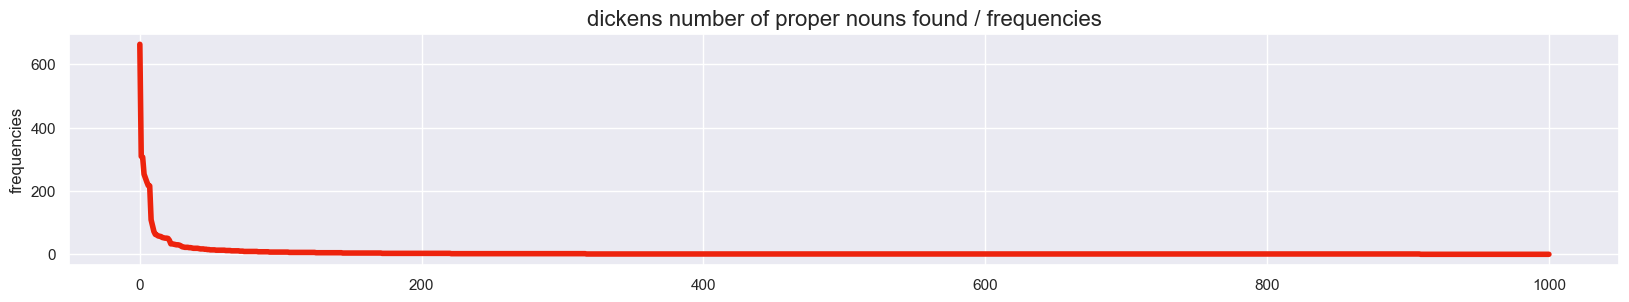

carroll: 218 names found


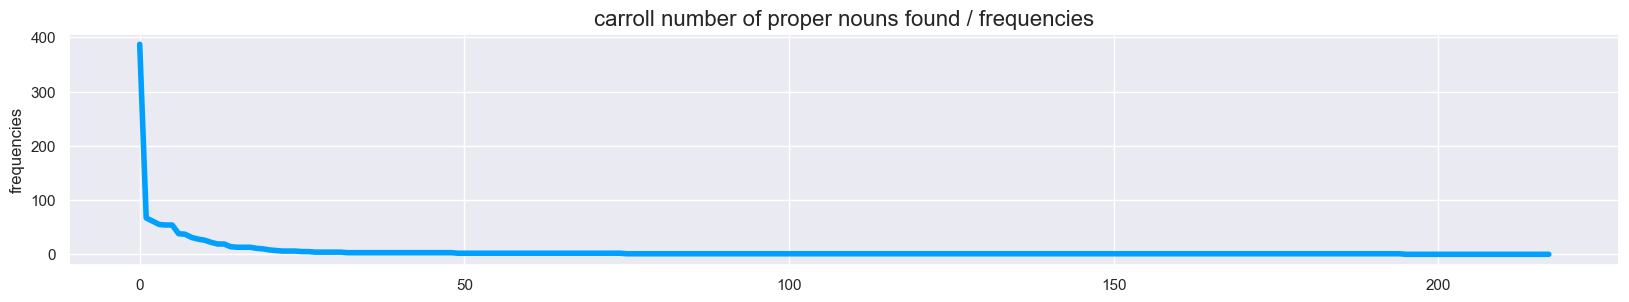

alcott: 1300 names found


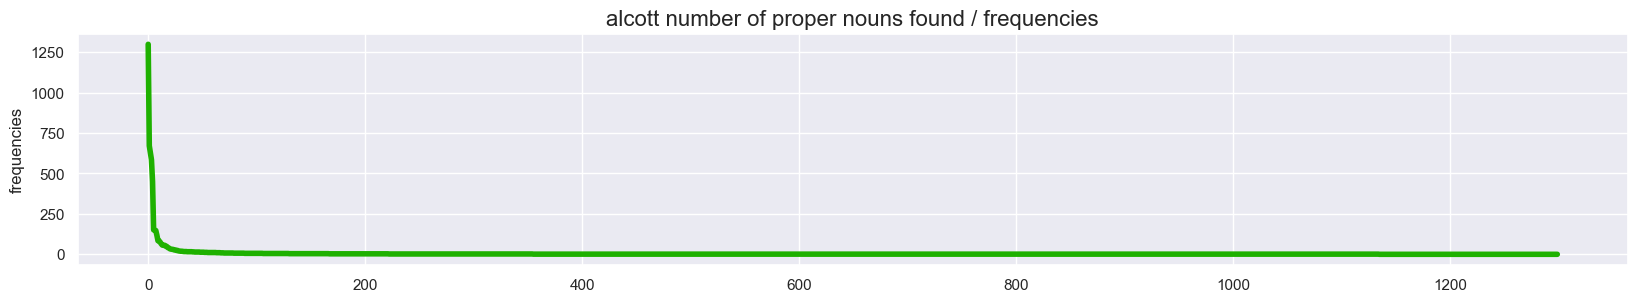

In [53]:
for author in authors:
    print(f'''{author}: {len(entities[author]['extraction_summary']['proper_nouns'])} names found''')
    ax = entities[author]['extraction_summary']['proper_nouns'].sort_values\
        (ascending = False).reset_index(drop=True).plot(color = author_colors[author], linewidth=4, figsize = (20, 3))
    plt.title(f'''{author} number of proper nouns found / frequencies''', fontsize = 16)
    plt.ylabel('frequencies')
    plt.show()

We can easily see how much noise is included in this raw dataset just by sampling some names. The objective is to eliminate very low frequency names either because they are noise (not actually character names) or because they are characters whose role is presumably very minor.

In [54]:
entities['alcott']['extraction_summary'].sample(5, random_state=2).style.apply(highlight_column, subset=['name'])        

,name,nltk_entities,spacy_entities,proper_nouns
593,Chester,6,9,2
1261,Great,0,0,1
374,Hearing,0,0,2
1120,Ward,1,1,1
1278,Montreux,1,0,1


##### Reduce entities based on count thresholds - ```reduce_entities()```

Since the proper noun extraction appeared to produce the best _quality_ names I decided to only look at names where proper noun extraction found at least one instance - and in combination with this the name had to be found at least 3 times by any one of the extraction methods. Arriving at these cutoffs took a bit of offline experimentation and was something of a manual process given that we don't have a labelled dataset, but in the end these criteria work reasonably well for all 3 books:

In [55]:
def reduce_entities(entity_dict, author):
    reduced_entities = \
        entity_dict[author]['extraction_summary'][((entity_dict[author]['extraction_summary']['nltk_entities'] > 2 ) | 
        (entity_dict[author]['extraction_summary']['spacy_entities'] > 2) |
        (entity_dict[author]['extraction_summary']['proper_nouns'] > 2)) & 
        (entity_dict[author]['extraction_summary']['proper_nouns'] != 0)].copy()
    return reduced_entities

In [56]:
# Get all entities / proper nouns with > 2 mentions
main_entities = {}
for author in authors:
    main_entities[author] = reduce_entities(entities, author)

Here we see the names have been reduced to a much more manageable number:

In [57]:
for author in authors:
    print(f'''{author}: {len(main_entities[author]['proper_nouns'])} names found''')

dickens: 225 names found
carroll: 51 names found
alcott: 234 names found


##### Eliminate WordNet locations - ```test_for_location()```

We can now test if a name is found as a WordNet location, and if so we drop it from the list:

In [58]:
def test_for_location(name):
    '''Takes in a name and uses Wordnet to check if the most common sense (which is always the first one)
    resolves to the hypernym 'location.n.01'.'''
    synset = wn.synsets(name)
    # The name may not occur in Wordnet (most person names don't)
    if len(synset) == 0:
        location = False
    # But if it does, check if it could occur as a location
    else:
        location = wn.synset('location.n.01') in synset[0].hypernym_paths()[0]
    return location

In [59]:
for author in authors:
    main_entities[author]['location'] = main_entities[author]['name'].apply(lambda x: test_for_location(x))
    to_drop = main_entities[author][main_entities[author]['location']==True].index
    main_entities[author].drop(to_drop, inplace = True)
    main_entities[author].reset_index(drop=True, inplace=True)

##### General cleanup steps - ```cleanup_entities()```

In [60]:
common_titles = ['Mr.', 'Mr', 'Mrs.', 'Mrs', 'Ms.', 'Ms', 'Miss', 
                 'Dr.', 'Dr', 'Rev.', 'Rev', 'Prof.', 'Prof']
def cleanup_entities(entity_dict, author, common_titles=common_titles):
    to_drop = []
    # Get names that are just common titles
    to_drop.extend(entity_dict[author][entity_dict[author]['name'].isin(common_titles)].index.tolist())
    # Get names that are only 1 character long
    to_drop.extend(entity_dict[author][entity_dict[author]['name'].str.len() == 1].index.tolist())
    # Get names that contain no alpha characters
    to_drop.extend(entity_dict[author][entity_dict[author]['name'].str.contains\
                                       (r'^[^a-zA-Z]*$', regex = True)].index.tolist())
    cleaned_entity_dict = entity_dict[author].copy()
    cleaned_entity_dict.drop(to_drop, inplace = True)
    cleaned_entity_dict.reset_index(drop=True)  
    return cleaned_entity_dict

In [61]:
for author in authors:
    main_entities[author] = cleanup_entities(main_entities, author)

Once again the number of names has been slightly reduced in all cases:

In [62]:
for author in authors:
    print(f'''{author}: {len(main_entities[author]['proper_nouns'])} names found''')

dickens: 208 names found
carroll: 49 names found
alcott: 213 names found


##### Reduce entities based on % mentions - ```final_cut_entities()```

In order to get a feel for how much 'space' a character takes up Sack ([2011](https://www.aaai.org/ocs/index.php/FSS/FSS11/paper/viewFile/4230/4528) citing Alex Woloch) , I looked at the mentions of each character as a % of the total mentions in our current list of names. Using a threshold of 0.1% (0.001 - again some iterations with manual review were required given the unlabelled dataset), I eliminated characters whose mention count was below this threshold as 'probably too minor to care about'. This step approximately halved the number of characters in ```dickens``` and ```alcott``` while leaving ```carroll``` as-is (the latter has much fewer minor characters compared to the other books). Our final frequency distributions are shown below:

In [63]:
def final_cut_entities(entity_dict, author):
    final_cut_entity_dict = entity_dict[author].copy()
    total_mentions = final_cut_entity_dict['proper_nouns'].sum()
    final_cut_entity_dict['proper_nouns_perc'] = final_cut_entity_dict['proper_nouns'].apply\
        (lambda x: round(x/total_mentions, 4))
    result = final_cut_entity_dict.query('proper_nouns_perc >= 0.001')
    return result

In [64]:
reduced_entities = {}
for author in authors:
    reduced_entities[author] = final_cut_entities(main_entities, author)

We are left with entities that have a percentage of proper nouns >= 0.001:

In [65]:
reduced_entities['dickens'].head().style.apply(highlight_column, subset=['proper_nouns_perc'])        

,name,nltk_entities,spacy_entities,proper_nouns,location,proper_nouns_perc
0,Herbert,306,307,307,False,0.065200
1,Church,2,0,6,False,0.001300
2,Mr. Wopsle,86,0,109,False,0.023200
3,Mr. Waldengarver,8,0,9,False,0.001900
4,Judge,0,0,9,False,0.001900


dickens: 131 names found


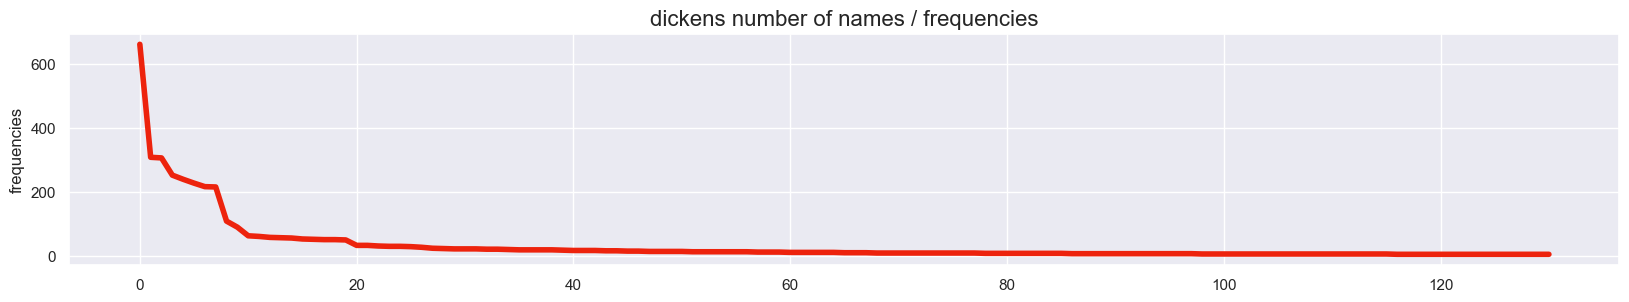

carroll: 49 names found


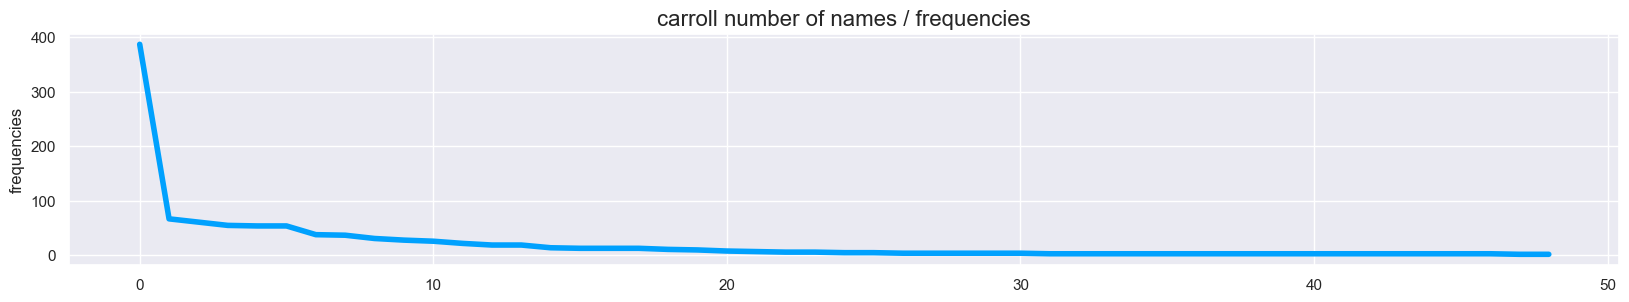

alcott: 94 names found


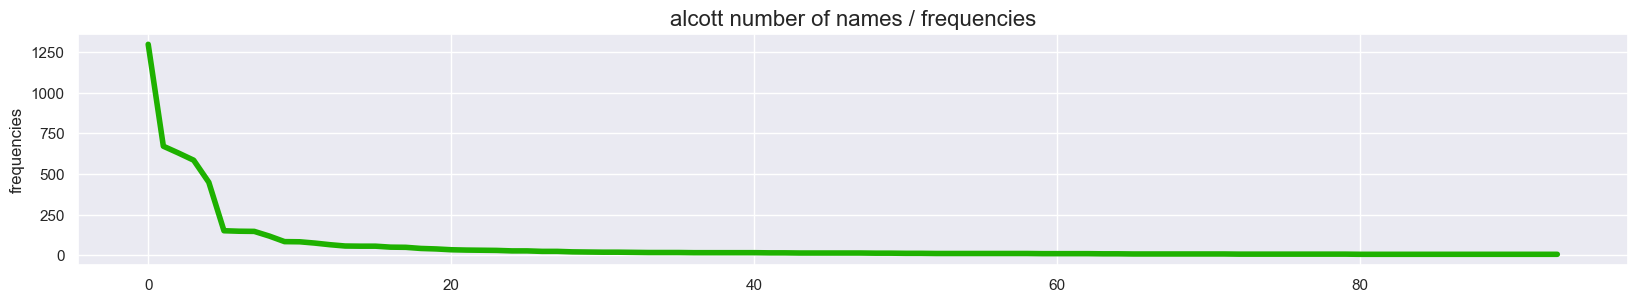

In [66]:
for author in authors:
    print(f'''{author}: {len(reduced_entities[author]['proper_nouns'])} names found''')
    ax = reduced_entities[author]['proper_nouns'].sort_values(ascending = False).reset_index\
        (drop=True).plot(color = author_colors[author], linewidth=4, figsize = (20, 3))
    plt.title(f'''{author} number of names / frequencies''', fontsize = 16)
    plt.ylabel('frequencies')
    plt.show()

## 2.7 Group similar names

The next objective is to relate a list of names like the following with a single common grouping 'index':

```['Herbert', 'Pocket', 'Herbert Pocket', 'Mrs. Pocket', 'Mr. Pocket', 'Mr. Matthew Pocket', 'Miss Sarah Pocket', 'Mr. Herbert', 'Sarah Pocket', 'Miss Pocket', 'Matthew Pocket']``` 

We can infer these are all related to one another in some way (although we cannot be sure how) as they share a similar group of individual names including 'Herbert', 'Pocket', 'Sarah', 'Matthew'.

This may seem slightly counter-intuitive BUT it is the most pragmatic way I can think of to deal with similar names. For instance if we read _Herbert_ we would easily say that _Herbert Pocket_ should be the same fellow. But what about when we come across _Mr. Pocket_? Once we know of the existence of _Matthew Pocket_ we can no longer be sure which man is being referred to with _Mr. Pocket_. To err on the side of caution my approach is to 'lasso' all names which could be related to one another into a single group.

With a small number of alternatives like this, we can then say they are aliases for the same character:

```['Cat', 'Cheshire Cat']``` 

The moment there are too many as above, then we err on the side of caution and just pick out the name with the single largest frequency as a character name we can be sure of, and leave the rest to one side as 'uncertain'.

The overall recipe for this section is:

1. Generate a set of name permutations so that we can check which single names are contained within multi-word names, like 'Herbert' contained within 'Herbert Pocket'
2. Where a set of names associated with a single word like 'Herbert', e.g. {'Herbert', 'Pocket'} overlaps with another set of names with a common element - say {'Sarah', 'Pocket'} - merge these names into a single group

[Given a little more time to experiment it would have been useful to see how we could refine this based on the conventions of first name (usually unique) and surname (often not unique).]

##### Group overlapping entities - ```group_entities()```

In [67]:
# Check for single names contained within multi-word names, and then group names with common elements
# We don't want to group names on their generic components like 'Mr.' or 'of'
name_stopwords = common_titles + ['of', 'Of', 'the' 'The']

def group_entities(entity_dict, author):
    # Get main list of names to test, e.g. 'Herbert Pocket'
    names_to_test = entity_dict[author]['name'].tolist()
    # Add single name components to this list e.g. 'Herbert', 'Pocket'
    names_to_test = names_to_test + list(set([item for sublist in [name.split(' ') \
                                   for name in names_to_test] for item in sublist if item not in name_stopwords]))
    # Generate name permutations
    permutations = list(itertools.permutations(names_to_test, r=2))

    relationships = []
    # Get the multi-name relationships
    for i in range(len(permutations)):
        test_case = permutations[i]
        if len(test_case[0].split(' ')) == 1:
            if re.search(rf'\b{test_case[0]}\b', test_case[1]):
                relationships.append(test_case)
    # Add the single name relationships
    single_names = [(name, name) for name in names_to_test]
    for name in single_names:
        if name not in relationships:
            relationships.append(name)
    # Group relationships by single names and their elements
    d = defaultdict(list)
    for key, value in relationships:
        d[key].append(value)
    d = dict(d)
    
    # Use 'successive merging' to build final name sets - method with thanks to Alain T. via this post:
    # https://stackoverflow.com/questions/56567089/combining-lists-with-overlapping-elements
    # - this uses sets and therefore intersection to check for overlapping elements (T., 2019)
    pooled = [set(subList) for subList in d.values()]
    merging = True
    while merging:
        merging=False
        for i,group in enumerate(pooled):
            merged = next((g for g in pooled[i+1:] if g.intersection(group)),None)
            if not merged: continue
            group.update(merged)
            pooled.remove(merged)
            merging = True
    pooled = [list(name_set) for name_set in pooled]
    names_df = pd.DataFrame(columns = ['name'])
    names_df['name'] = pooled
    names_df = names_df.explode('name')
    names_df.reset_index(inplace=True)
    
    merged_df = entity_dict[author].copy()
    merged_df = merged_df.merge(names_df, how = 'left', on = 'name')
    
    # Get total character mentions per index
    totals = pd.DataFrame(merged_df.groupby(by = ['index'])['proper_nouns'].sum())
    totals.reset_index(inplace = True)

    # Get character counts per index
    counts = pd.DataFrame(merged_df.groupby(by = ['index'])['name'].count())
    counts.reset_index(inplace = True)
    counts.columns = ['index', 'char_count']
    
    # Merge character totals and counts into final entities
    merged_df = merged_df.merge(totals, how = 'left', on = 'index', suffixes = ('_ind_totals', '_grp_totals'))
    merged_df = merged_df.merge(counts, how = 'left', on = 'index', )
    
    return merged_df

In [68]:
merged_entities = {}
for author in authors:
    merged_entities[author] = group_entities(reduced_entities, author)

Here we see that all the names containing _Pocket_ now share the same index:

In [69]:
merged_entities['dickens'][merged_entities['dickens']['name'].str.contains\
                           ('Pocket')].style.apply(highlight_column, subset=['name', 'index'])

,name,nltk_entities,spacy_entities,proper_nouns_ind_totals,location,proper_nouns_perc,index,proper_nouns_grp_totals,char_count
48,Sarah Pocket,10,17,13,False,0.002800,0,469,10
79,Miss Pocket,6,1,7,False,0.001500,0,469,10
80,Mr. Pocket,38,0,50,False,0.010600,0,469,10
98,Miss Sarah Pocket,4,0,6,False,0.001300,0,469,10
109,Mrs. Pocket,0,0,53,False,0.011300,0,469,10
113,Mr. Matthew Pocket,6,0,6,False,0.001300,0,469,10
125,Herbert Pocket,4,6,5,False,0.001100,0,469,10


And also all the names associated with, but not necessarily containing, _Pocket_ also share the same index:

In [70]:
index_to_view = merged_entities['dickens'][merged_entities['dickens']['name'].str.contains\
                                           ('Pocket')].iloc[0]['index']
merged_entities['dickens'][merged_entities['dickens']['index'] == index_to_view].style.apply\
    (highlight_column, subset=['name', 'index'])

,name,nltk_entities,spacy_entities,proper_nouns_ind_totals,location,proper_nouns_perc,index,proper_nouns_grp_totals,char_count
0,Herbert,306,307,307,False,0.065200,0,469,10
48,Sarah Pocket,10,17,13,False,0.002800,0,469,10
67,Sarah,12,9,8,False,0.001700,0,469,10
69,Matthew,12,16,14,False,0.003000,0,469,10
79,Miss Pocket,6,1,7,False,0.001500,0,469,10
80,Mr. Pocket,38,0,50,False,0.010600,0,469,10
98,Miss Sarah Pocket,4,0,6,False,0.001300,0,469,10
109,Mrs. Pocket,0,0,53,False,0.011300,0,469,10
113,Mr. Matthew Pocket,6,0,6,False,0.001300,0,469,10
125,Herbert Pocket,4,6,5,False,0.001100,0,469,10


##### Extract final entities - ```extract_final_entities()```

Our final step is to get the name per grouping that has the most mentions, we'll treat this as they 'key value' for the indices we've established:

In [71]:
def extract_final_entities(entity_dict, author):
    final_entities = entity_dict[author].copy()
    # Get the maximum per index for each character grouping based on proper_nouns_ind_totals
    max_records = final_entities.groupby('index', group_keys=False).apply\
        (lambda x: x.loc[x['proper_nouns_ind_totals'].idxmax()])
    # Get the records where we can only keep one name as there may be ambiguities (> 3 'variants')
    singletons = max_records[max_records['char_count'] > 3].reset_index(drop=True)
    # Drop these ambiguous records from our main df
    to_drop = final_entities[final_entities['index'].isin(singletons['index'])].index
    final_entities.drop(to_drop, inplace = True)
    # And just re-include the singleton records we can be more sure about
    final_entities = pd.concat([final_entities, singletons])
    # Merge final_entities with max_records to get the single names representative of name variants
    max_records.reset_index(drop = True, inplace = True)
    final_entities = final_entities.merge(max_records[['index', 'name']], \
                                          how = 'left', on='index', suffixes=('_original', '_key'))
    final_entities.rename(columns={'name_original':'name', 'name_key': 'key'}, inplace=True)
    return final_entities

In [72]:
final_entities = {}
for author in authors:
    final_entities[author] = extract_final_entities(merged_entities, author)

# Check that the outputs are as expected
final_entities['dickens'][final_entities['dickens']['name'].str.contains\
                          ('Herbert|Pocket|Pip')].style.apply(highlight_column, subset=['name', 'index', 'key'])

,name,nltk_entities,spacy_entities,proper_nouns_ind_totals,location,proper_nouns_perc,index,proper_nouns_grp_totals,char_count,key
45,Pip,204,237,253,False,0.053800,33,310,2,Pip
100,Mr. Pip,57,0,57,False,0.012100,33,310,2,Pip
108,Herbert,306,307,307,False,0.065200,0,469,10,Herbert


Above we are seeing that where we have name variants we can say are associated with reasonable certainty (< 3 variants) they have been retained and are grouped with a common index: see _Pip_. However, where there were name variants that we could not say for sure what the associations were only the single instance with the most mentions has been retained: see _Herbert_ which has been selected from amongst all the _Pocket_ names. 

\[If I were to refine this method a little more I would look at possible first name / last name associations to see if genuinely related names could be extracted in slightly more detail, but that is again outside of the scope of this particular investigation.\]

## 2.8 Save key information to our database

### 2.8.1 Save ```book_entities```

In [73]:
book_entities_sql = book_entities.copy()
# Get the book entities into a format where we can save it to the DB (which does not like lists or tuples)
book_entities_sql['nltk_entities'] = book_entities_sql['nltk_entities'].apply\
    (lambda x: ';'.join(map(str, x)) if x != None else 'None')
book_entities_sql['spacy_entities'] = book_entities_sql['spacy_entities'].apply\
    (lambda x: ';'.join(map(str, x)) if x != None else 'None')
book_entities_sql['lemmas'] = book_entities_sql['lemmas'].apply\
    (lambda x: ';'.join(x) if x != None else 'None')
book_entities_sql['proper_nouns'] = book_entities_sql['proper_nouns'].apply\
    (lambda x: ';'.join(x) if x != None else 'None')

In [74]:
# We can always convert back again with the following recipes:

# For NER (which has tuples)
# book_entities_sql['nltk_entities'].apply(lambda x: [tuple(re.sub(r'[\(\)\']', '', item).split(', ')) \
# for item in x.split(';')] if x != 'None' else None)

# For proper nouns (which has lists)
# book_entities_sql['proper_nouns'].apply(lambda x: x.split(';') if x != 'None' else None)

In [75]:
# Save the outputs to our db
book_entities_sql.to_sql('book_entities', connection, schema=None, 
              if_exists='replace', index=True)

20144

### 2.8.2 Save ```final_entities```

In [76]:
# Save to the database
for author in authors:
    table_name = author + '_entities'
    final_entities[author].to_sql(table_name, connection, schema=None, 
              if_exists='replace', index=True)

In [77]:
# And check that it landed safely
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///book_store.db
Done.


name
chapter_headings
book_components
dickens_vocab
carroll_vocab
alcott_vocab
bronte_vocab
wikidata
book_entities
dickens_entities
carroll_entities


## 3 Evaluation

### 3.1.1 Loop in our 4th unseen book ```bronte```

The final 'recipe' was developed and refined on ```dickens```, ```carroll``` and ```alcott```. Before we evaluate I'm now going to add ```bronte``` so that we can evaluate the final results not only on the books used in the development process but on one that hasn't been seen before.

In [78]:
# Get bronte from our db
processed_books['bronte'] = pd.read_sql_query\
    ('SELECT * FROM book_components WHERE author IN ("bronte")', 'sqlite:///book_store.db')
processed_books['bronte']['lemmas'] = processed_books['bronte']['lemmas'].apply(lambda x: x.split(';'))

# Replace punctuation
for before, after in punctuation_replacements.items():
    processed_books['bronte']['text'] = processed_books['bronte']['text'].str.replace(before, after)
    
# Get named entities
processed_books['bronte']['nltk_entities'] = processed_books['bronte']['text'].progress_apply\
    (lambda x: get_named_entities_nltk(x))
processed_books['bronte']['spacy_entities'] = processed_books['bronte']['text'].progress_apply\
    (lambda x: get_named_entities_spacy(x))

# Get proper nouns
processed_books['bronte']['proper_nouns'] = processed_books['bronte']['text'].progress_apply\
    (lambda x: get_proper_nouns_nltk(x))

# Get name frequencies and trim lists
for author in ['bronte']:
    # Compile entities
    entities[author] = {}
    for extraction_type in extraction_types:
        entities[author][extraction_type] = compile_entities(processed_books, author=author, \
                                                             extraction_type=extraction_type)
    # Combine entities 
    entities[author]['extraction_summary'] = combine_entities(entities, author=author, \
                                                              extraction_types=extraction_types)
    # Reduce entities
    main_entities[author] = reduce_entities(entities, author)
    # Remove locations   
    main_entities[author]['location'] = main_entities[author]['name'].apply(lambda x: test_for_location(x))
    to_drop = main_entities[author][main_entities[author]['location']==True].index
    main_entities[author].drop(to_drop, inplace = True)
    main_entities[author].reset_index(drop=True, inplace=True)
    # General cleanup    
    main_entities[author] = cleanup_entities(main_entities, author)
    # Final cut    
    reduced_entities[author] = final_cut_entities(main_entities, author)
    # Group entities
    merged_entities[author] = group_entities(reduced_entities, author)  
    # Extract final entities
    final_entities[author] = extract_final_entities(merged_entities, author)

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

  0%|          | 0/9632 [00:00<?, ?it/s]

### 3.1.2 Get Wikidata into the right format for lookup

In this step I will transform our Wikidata list of characters such that each index represents a 'main name' for the character and aliases are associated with that index.

In [79]:
# Read in the wikdata characters from our database
wikidata = pd.read_sql_query('SELECT * FROM wikidata WHERE property = "characters"', 'sqlite:///book_store.db')

In [80]:
# Transform the string format back to a list / tuple format
wikidata['data'] = wikidata['data'].apply(lambda x: [(name, alias.split('|')) \
if '|' in alias else (name, alias) for name, alias in [tuple(item.split('^'))  
if '^' in item else (item, 'None') for item in x.split(';')]])

Here we assemble the final Wikidata list so that ```index``` is the unique id for each character, ```key``` is the 'main' name assigned to the character and ```name``` is the list of all names associated with that character:

In [81]:
wikidata_chars = {}
for author in all_authors:
    wiki_char_list = wikidata.query('author == @author  and property == "characters"')['data'].tolist()
    wiki_char_df = pd.DataFrame(wiki_char_list[0], columns =['key', 'name'])
    # We're keeping the index here as our unique character key
    wiki_char_df.reset_index(inplace = True)
    # Get the rows which have aliases
    aliases_df = wiki_char_df[wiki_char_df['name'].notna()]
    # Each name should be associated with itself as an alias for convenience when matching later
    wiki_char_df['name'] = wiki_char_df['key']
    # Group the main names and the aliases together
    wiki_char_df = pd.concat([wiki_char_df, aliases_df])
    wiki_char_df = wiki_char_df.explode('name')
    wikidata_chars[author] = wiki_char_df.sort_values('index').reset_index(drop= True)
    
# Check that the output is as expected
wikidata_chars['bronte'].head(10)

,index,key,name
0,0,Jane Eyre,Jane Eyre
1,0,Jane Eyre,None
2,1,Mr. Rochester,Mr. Rochester
3,1,Mr. Rochester,Edward Fairfax Rochester
4,1,Mr. Rochester,Edward Rochester
5,2,Bertha Mason,Bertha Mason
6,2,Bertha Mason,Bertha Antoinetta Mason
7,2,Bertha Mason,Antoinette Cosway
8,2,Bertha Mason,Bertha Mason Rochester
9,3,St. John Rivers,St. John Rivers


There is one manual adjustment I'm going to make to this list: Wikidata lists a character _Alice's sister_, however this character is never actually named in the book and therefore I'm going to exclude it for purposes of our evaluation.

In [82]:
to_drop = wikidata_chars['carroll'][wikidata_chars['carroll']['key'] == "Alice's sister"].index
wikidata_chars['carroll'] = wikidata_chars['carroll'].drop(to_drop).reset_index(drop = True)

### 3.1.3 Match names found

In this step I match names found in Wikidata to names found in our final entities data:

In [83]:
for author in all_authors:
    keys_to_match = dict(zip(wikidata_chars[author]['name'], wikidata_chars[author]['key']))
    final_entities[author]['wiki_terms_key'] = final_entities[author]['key'].apply\
        (lambda x: '; '.join(list(set([key for name, key in keys_to_match.items() if re.search\
                                       (rf'\b{x}\b', name) or re.search(rf'\b{name}\b', x)]))))
    indices_to_match = dict(zip(wikidata_chars[author]['name'], wikidata_chars[author]['index']))
    final_entities[author]['wiki_terms_index'] = final_entities[author]['key'].apply\
        (lambda x: '; '.join(list(set([str(index) for name, index in indices_to_match.items() \
                                       if re.search(rf'\b{x}\b', name) or re.search(rf'\b{name}\b', x)]))))

### 3.1.4 Manual review of top 20 names and "precision"

Remember that precision answers the question '_Of the results we got, how many were valid?_'. As mentioned previously, this is by necessity a manual exercise, since we do not have exhaustive character lists from Wikidata. I will be limiting the character visualizations in the next section to only the top 20 per novel, so I'm going to assess how many of these top 20 were valid results. Top 20 refers to the top 20 'indexes' found so _Pip_ and _Mr. Pip_ will count as one name.

In evaluating if a name is valid or not, 2 aspects have to be considered - I have chosen to handle them as follows:

* Was the name identified a valid character name? (if not -1 from score)
* Was the name identified genuine, but not picked up as being an alias for another? (in this case -0.5 from score)

The method of scoring is rather arbitrary - it should only be viewed as a rough guide to evaluation.

In [84]:
fields_of_interest = ['name', 'key', 'index', 'proper_nouns_ind_totals', 'proper_nouns_grp_totals', 'wiki_terms_key', 'wiki_terms_index']

In [85]:
top_20 = {}
for author in all_authors:
    unique_indices_totals = final_entities[author][['index', 'proper_nouns_grp_totals']].drop_duplicates()
    top_indices = unique_indices_totals.nlargest(20, 'proper_nouns_grp_totals')['index'].tolist()
    top_20[author] = final_entities[author][final_entities[author]['index'].isin(top_indices)]

#### Dickens top 20

By way of reminder: ```dickens``` had the smallest set of characters in Wikidata - below (check field ```wiki_terms_key```) we see which matches were found in our data:

In [86]:
print(f'''Number of unique Wikidata characters: {len(wikidata_chars['dickens']['key'].unique())}

Wikidata character list excluding aliases: 
{wikidata_chars['dickens']['key'].unique().tolist()}
''')
top_20['dickens'][fields_of_interest].sort_values('index', ascending = False)

Number of unique Wikidata characters: 6

Wikidata character list excluding aliases: 
['Pip', 'Miss Havisham', 'Estella', 'Abel Magwitch', 'John Wemmick', 'Compeyson']



,name,key,index,proper_nouns_ind_totals,proper_nouns_grp_totals,wiki_terms_key,wiki_terms_index
5,Miss Skiffins,Miss Skiffins,95,31,31,,
9,Mr. Jaggers,Mr. Jaggers,87,216,216,,
93,Aged,Aged,76,51,51,,
13,Mr. Pumblechook,Mr. Pumblechook,72,90,162,,
89,Pumblechook,Mr. Pumblechook,72,52,162,,
61,Uncle Pumblechook,Mr. Pumblechook,72,20,162,,
110,Joe,Joe,68,663,750,,
101,Miss Havisham,Miss Havisham,67,309,315,Miss Havisham,1
83,Havisham,Miss Havisham,67,6,315,Miss Havisham,1
109,Orlick,Orlick,38,33,90,,


#### Comparison to Wikidata

Notice the following:

* _Abel Magwitch_, although listed as a main character by WikiData, is not found in our top 20. This highlights 2 issues: 1) inability to match aliases: we have _Provis_ which is in fact an alias for _Magwitch_ but we have no way of knowing they are one and the same character and 2) some characters loom large, even if they are not frequently mentioned by name. In the beginning of __Great Expectations__ our hero _Pip_ has an encounter with _Magwitch_ which alters the course of his life, but in ways we really only understand later when _Magwitch_ returns to the narrative as _Provis_.
* Notice also, the name _Drummle_ is associated only with _Estella Drummle_ in Wikidata so there is some confusion on the matching between our data and Wikidata in this instance. Availability of a more comprehensive character list in Wikidata would have helped to alleviate this evaluation issue!

#### Precision of dickens top 20

* Most of the names in the top 20 are genuine names (even _Aged_ - there is actually a character referred to as _Aged P._ or _Aged Parent_ in the book!)
* _Sunday_ is the only name that is incorrect (-1)
* _Handel_ is one of Pip's nicknames (-0.5)


Our manual precision calculation is therefore:

$$ \frac{TP}{TP + FP} = \frac{18.5}{20} = 0.93$$ 

#### Carroll top 20

By way of reminder: ```carroll``` had quite a few unusual characters - below we see which matches were found in our data - surprisingly comprehensive:

In [87]:
print(f'''Number of unique Wikidata characters: {len(wikidata_chars['carroll']['key'].unique())}

Wikidata character list excluding aliases: 
{wikidata_chars['carroll']['key'].unique().tolist()}
''')
top_20['carroll'][fields_of_interest].sort_values('index', ascending = False)

Number of unique Wikidata characters: 21

Wikidata character list excluding aliases: 
['Alice', 'White Rabbit', 'Mouse', 'Dodo', 'Lory', 'Eaglet', 'Duck', 'Duchess', 'Caterpillar', 'Gryphon', 'Dormouse', 'Knave of Hearts', 'The Hatter', 'Bill the Lizard', 'Cheshire Cat', 'March Hare', 'Queen of Hearts', 'Mock Turtle', 'King of Hearts', 'Dinah', 'Father William']



,name,key,index,proper_nouns_ind_totals,proper_nouns_grp_totals,wiki_terms_key,wiki_terms_index
34,Mock Turtle,Mock Turtle,41,54,54,Mock Turtle,17
8,March Hare,March Hare,39,31,31,March Hare,15
43,Come,Come,37,13,13,,
31,Cat,Cat,28,22,26,Cheshire Cat,14
39,Cheshire Cat,Cat,28,4,26,Cheshire Cat,14
25,Hatter,Hatter,24,54,54,The Hatter,12
23,Bill,Bill,22,13,13,Bill the Lizard,13
21,Pigeon,Pigeon,20,11,11,,
19,Alice,Alice,18,387,387,Alice,0
38,White Rabbit,Rabbit,17,19,41,White Rabbit,1


#### Comparison to Wikidata

The results are surprisingly good, with similar variants of names being correctly grouped - except where we could not be sure how to understand relationships. For example it's disappointing the _Queen_ does not also include the variant _Queen of Hearts_, but as discussed above, this is as a result of the similar name _Knave of Hearts_ confusing matters.

Also (somewhat randomly!) _King_ has been extracted successfully as a separate character from the _Queen_ / _Queen of Hearts_ because in the book he is never referenced as _King of Hearts_ although that is what he is. Because of this no room for doubt was created.

#### Review of precision

* Most of the names in the top 20 are genuine names 
* _Come_ is the only name that is shouldn't be in the list (-1)
* _Majesty_, is ambiguous: does it refer to the King or the Queen or both? We can't know without context (-0.5)
* _Footman_ is also ambiguous, there are in fact 2 footmen, the _Frog-Footman_ and the _Fish-Footman_ (-0.5)



Our manual precision calculation is therefore:

$$ \frac{TP}{TP + FP} = \frac{18}{20} = 0.90$$ 

#### Alcott top 20

By way of reminder: ```alcott``` was essentially about the _March_ family so everyone could have the surname _March_. Wikidata had an extremely comprehensive character list compared with Dickens. Below we see which matches were found in our data - where ```wiki_terms_index``` contains more than one item we cannot be sure if the character is a match or not:

In [88]:
print(f'''Number of unique Wikidata characters: {len(wikidata_chars['alcott']['key'].unique())}

Wikidata character list excluding aliases: 
{wikidata_chars['alcott']['key'].unique().tolist()}
''')
top_20['alcott'][fields_of_interest].sort_values('index', ascending = False)

Number of unique Wikidata characters: 61

Wikidata character list excluding aliases: 
['Jo March', 'Meg March', 'Beth March', 'Amy March', 'Laurie', 'Aunt March', 'Marmee March', 'Mr. March', 'Hannah Mullet', 'Mrs. Hummel', 'Lottchen Hummel', 'Mrs. Gardiner', 'Sallie Gardiner', 'Annie Moffat', 'Aunt Carrol', 'Florence Carrol', 'Mr. Davis', 'Mr. Laurence', 'John Brooke', 'Friedrich Bhaer', 'Mrs. Kirke', 'Tina', 'Uncle Carrol', 'Ned Moffat', 'Belle Moffat', 'Dr. Bangs', 'Kitty Bryant', 'Minna Hummel', 'Heinrich Hummel', 'Fred Vaughn', 'Frank Vaughn', 'Kate Vaughn', 'Grace Vaughn', 'Kitty Kirke', 'Minnie Kirke', 'Miss Norton', 'Mr. Dashwood', 'Daisy Brooke', 'Demi Brooke', 'Mrs. Moffat', 'Mr. Moffat', 'Hortense', 'Mrs. Crocker', 'Jack Scott', 'Esther', 'Mary Kingsley', 'Jenny Snow', 'Clara Moffat', 'Grace King', 'Ellen King', 'Mr. King', 'Mrs. King', 'Susie Perkins', 'Mr. Tudor', 'Miss Eliott', 'May Chester', 'Mrs. Chester', 'Mrs. Lamb', 'Miss Lamb', 'Mr. Lamb', 'Katy Brown']



,name,key,index,proper_nouns_ind_totals,proper_nouns_grp_totals,wiki_terms_key,wiki_terms_index
74,Laurie,Laurie,62,585,585,Laurie,4
73,Amy,Amy,61,629,629,Amy March,3
70,Christmas,Christmas,58,32,32,,
80,Mr. Bhaer,Mr. Bhaer,49,56,129,,
55,Father,Father,48,83,83,,
51,Sallie,Sallie,44,39,39,Sallie Gardiner,12
50,Fred,Fred,43,49,49,Fred Vaughn,29
63,Mr. Laurence,Mr. Laurence,37,75,81,Mr. Laurence,17
41,Laurence,Mr. Laurence,37,6,81,Mr. Laurence,17
38,Marmee,Marmee,35,42,42,Marmee March,6


#### Review of precision

* Most of the names in the top 20 are genuine names (_May_ is a real character not a month!)
* _Christmas_ and _Poor_ are the only names that shouldn't be in the list (-2)
* _Teddy_ and _Laurie_ are ambiguous - they are one and the same person (2 x -0.5)
* _Mrs. March_, _Mother_, _Marmee_ are ambiguous - they are one and the same person (3 x -0.5)


Our manual precision calculation is therefore:

$$ \frac{TP}{TP + FP} = \frac{15.5}{20} = 0.78$$ 

#### Bronte top 20

```bronte``` also has a small set of characters in Wikidata - below (check field ```wiki_terms_key```) we see which matches were found in our data:

In [89]:
print(f'''Number of unique Wikidata characters: {len(wikidata_chars['bronte']['key'].unique())}

Wikidata character list excluding aliases: 
{wikidata_chars['bronte']['key'].unique().tolist()}
''')
top_20['bronte'][fields_of_interest].sort_values('index', ascending = False)

Number of unique Wikidata characters: 6

Wikidata character list excluding aliases: 
['Jane Eyre', 'Mr. Rochester', 'Bertha Mason', 'St. John Rivers', 'Diana Rivers', 'Mary Rivers']



,name,key,index,proper_nouns_ind_totals,proper_nouns_grp_totals,wiki_terms_key,wiki_terms_index
115,God,God,95,96,96,,
111,Hannah,Hannah,91,39,39,,
100,Georgiana,Georgiana,83,36,42,,
46,Miss Georgiana,Georgiana,83,6,42,,
42,Miss Temple,Miss Temple,71,56,59,,
84,Temple,Miss Temple,71,3,59,,
82,Grace,Grace Poole,69,12,37,,
87,Mrs. Poole,Grace Poole,69,8,37,,
35,Grace Poole,Grace Poole,69,17,37,,
76,Burns,Helen,66,9,69,,


#### Comparison to Wikidata

There were only 3 characters listed on Wikidata - we got them!

#### Precision of bronte top 20

* Most of the names in the top 20 are genuine names (including _St. John_, pronounced 'sinjin' when it is someone's name)
* _Did_, _Thornfield_ and _Lowood_ are the 3 names that are incorrect (-3)
* _God_ is debatable (-0.5)


Our manual precision calculation is therefore:

$$ \frac{TP}{TP + FP} = \frac{16.5}{20} = 0.83$$ 

### 3.1.5 Recall

I'm going to look at recall from 2 points of view:

__1. Overall, of the results we should have obtained (Wikidata list), how many did we get?__

Recall is influenced by the number of items that are in the Wikidata lists. __Great Expectations__ actually has many more characters, but only the 6 very _main_ ones were given, where with __Little Women__ 61 characters were given, many of whom really are quite minor.

__2. In the Top 20, of the results we should have obtained (Wikidata list), how many did we get?__

This latter is not really 'recall' but gives us an indication of how many of the characters we wanted to get actually turned up in the Top 20.

Here I create and process a function to compile the results and store them:

In [90]:
def compile_recall_data(final_entities_dict):
    recall_tracking = {}
    for author in all_authors:
        recall_tracking[author] = {}
        wiki_items = wikidata_chars[author]['key'].unique().tolist()
        found_items = final_entities_dict[author].loc[(final_entities_dict[author]['wiki_terms_key'] != '') & \
                     (~final_entities_dict[author]['wiki_terms_key'].str.contains(';')), \
                                                      'wiki_terms_key'].unique().tolist()
        other_items = final_entities_dict[author].loc[~final_entities_dict[author]['wiki_terms_key'].isin\
                                                      (found_items), 'key'].unique().tolist()
        recall_tracking[author]['wiki_items'] = len(wiki_items)
        recall_tracking[author]['found'] = len(found_items)
        recall_tracking[author]['not_found'] = len(list(set(wiki_items).difference(set(found_items))))
        recall_tracking[author]['recall'] = len(found_items) / len(wiki_items)
        recall_tracking[author]['found_items'] = found_items
        recall_tracking[author]['not_found_items'] = list(set(wiki_items).difference(set(found_items)))
        recall_tracking[author]['other_items'] = other_items
    return recall_tracking

In [91]:
overall_tracking = compile_recall_data(final_entities)
top20_tracking = compile_recall_data(top_20)

### 3.1.6 Overall results

Below we see, of the results we should have obtained (Wikidata list), how many we got from the final list of characters (pie chart sizes are notionally relative to the number of characters that were listed in Wikidata):

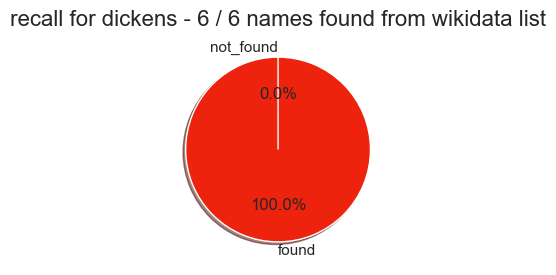

Found from Wikidata: 
    
    ['Abel Magwitch', 'Compeyson', 'Estella', 'John Wemmick', 'Miss Havisham', 'Pip']

Not found from Wikidata:

    []


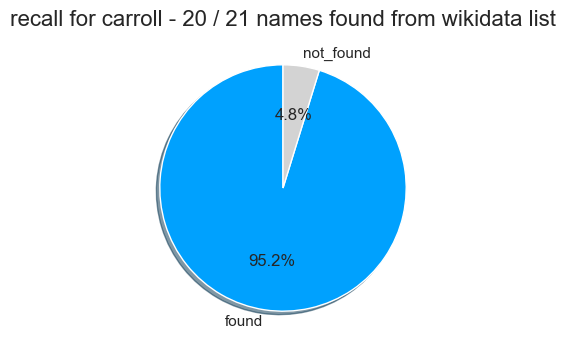

Found from Wikidata: 
    
    ['Alice', 'Bill the Lizard', 'Caterpillar', 'Cheshire Cat', 'Dinah', 'Dodo', 'Dormouse', 'Duchess', 'Duck', 'Eaglet', 'Father William', 'Gryphon', 'King of Hearts', 'Lory', 'March Hare', 'Mock Turtle', 'Mouse', 'Queen of Hearts', 'The Hatter', 'White Rabbit']

Not found from Wikidata:

    ['Knave of Hearts']


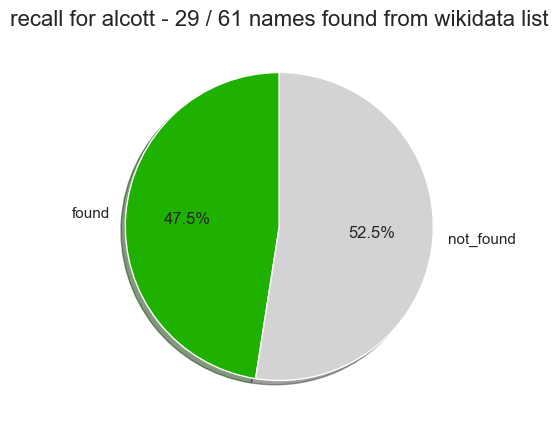

Found from Wikidata: 
    
    ['Amy March', 'Belle Moffat', 'Beth March', 'Daisy Brooke', 'Demi Brooke', 'Dr. Bangs', 'Esther', 'Florence Carrol', 'Frank Vaughn', 'Fred Vaughn', 'Friedrich Bhaer', 'Hannah Mullet', 'Jack Scott', 'Jo March', 'Laurie', 'Marmee March', 'May Chester', 'Meg March', 'Miss Norton', 'Mr. Dashwood', 'Mr. Davis', 'Mr. Laurence', 'Mrs. Chester', 'Mrs. Kirke', 'Mrs. Moffat', 'Ned Moffat', 'Sallie Gardiner', 'Tina', 'Uncle Carrol']

Not found from Wikidata:

    ['Annie Moffat', 'Aunt Carrol', 'Aunt March', 'Clara Moffat', 'Ellen King', 'Grace King', 'Grace Vaughn', 'Heinrich Hummel', 'Hortense', 'Jenny Snow', 'John Brooke', 'Kate Vaughn', 'Katy Brown', 'Kitty Bryant', 'Kitty Kirke', 'Lottchen Hummel', 'Mary Kingsley', 'Minna Hummel', 'Minnie Kirke', 'Miss Eliott', 'Miss Lamb', 'Mr. King', 'Mr. Lamb', 'Mr. March', 'Mr. Moffat', 'Mr. Tudor', 'Mrs. Crocker', 'Mrs. Gardiner', 'Mrs. Hummel', 'Mrs. King', 'Mrs. Lamb', 'Susie Perkins']


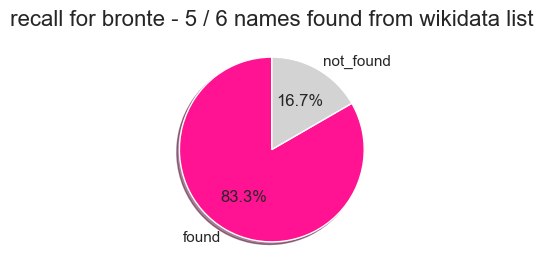

Found from Wikidata: 
    
    ['Bertha Mason', 'Diana Rivers', 'Jane Eyre', 'Mr. Rochester', 'St. John Rivers']

Not found from Wikidata:

    ['Mary Rivers']


In [92]:
# Pie chart sizes are notionally relative to the number of characters that were listed in Wikidata:
labels = ['found', 'not_found']
relative_wikidata_sizes = {'dickens': (3,3), 'carroll': (4, 4), 'alcott': (5, 5), 'bronte': (3,3)}
for author in all_authors:
    data = [overall_tracking[author]['found'], overall_tracking[author]['not_found']]
    fig1, ax = plt.subplots(figsize=relative_wikidata_sizes[author])

    ax.pie(x=data, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors = [author_colors[author], 'lightgrey'])
    plt.title(f'''recall for {author} - {overall_tracking[author]['found']} / \
{len(wikidata_chars[author]['key'].unique())} names found from wikidata list''', fontsize = 16)
    plt.show()
    
    print(f'''Found from Wikidata: 
    
    {sorted(overall_tracking[author]['found_items'])}

Not found from Wikidata:

    {sorted(overall_tracking[author]['not_found_items'])}''')

One can see above how imperfect the metric is, being heavily influenced by the level of detail available in WikiData. Notwithstanding, I'm satisfied with these results: even in the case of ```alcott```, to find 29 of the given 61 names is acceptable - especially given that the 29 contains all the characters that are usually top of mind for me as a human reader: _Jo_, _Meg_, _Amy_, _Beth_, _Laurie_, _Marmee_.

### 3.1.7 Top 20 results

Below we see, of the results we should have obtained (Wikidata list), how many we got from in the Top 20 list of characters:

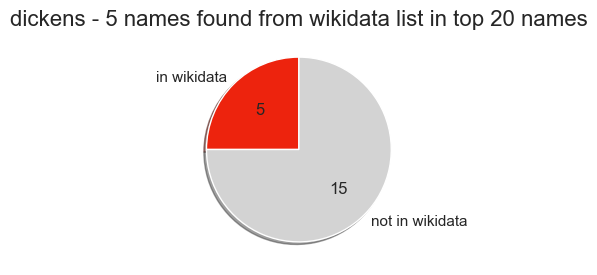

Found from Wikidata: 
    
    ['Compeyson', 'Estella', 'John Wemmick', 'Miss Havisham', 'Pip']

Not from Wikidata:

    ['Aged', 'Biddy', 'Handel', 'Herbert', 'Joe', 'Miss Skiffins', 'Mr. Jaggers', 'Mr. Pumblechook', 'Mr. Wopsle', 'Orlick', 'Provis', 'Startop', 'Sunday', 'Trabb']


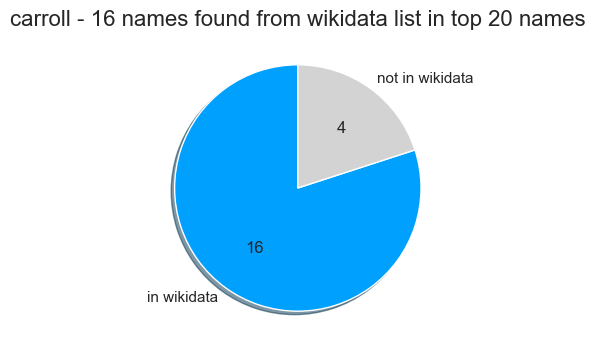

Found from Wikidata: 
    
    ['Alice', 'Bill the Lizard', 'Caterpillar', 'Cheshire Cat', 'Dinah', 'Dodo', 'Dormouse', 'Duchess', 'Gryphon', 'King of Hearts', 'March Hare', 'Mock Turtle', 'Mouse', 'Queen of Hearts', 'The Hatter', 'White Rabbit']

Not from Wikidata:

    ['Come', 'Footman', 'Majesty', 'Pigeon']


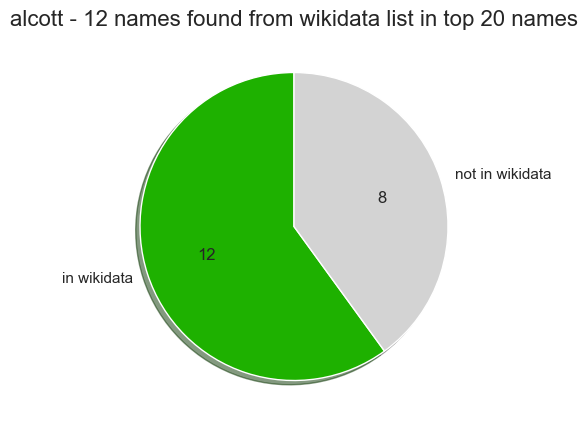

Found from Wikidata: 
    
    ['Amy March', 'Beth March', 'Demi Brooke', 'Fred Vaughn', 'Hannah Mullet', 'Jo March', 'Laurie', 'Marmee March', 'May Chester', 'Meg March', 'Mr. Laurence', 'Sallie Gardiner']

Not from Wikidata:

    ['Christmas', 'Father', 'God', 'John', 'Mother', 'Mr. Bhaer', 'Teddy']


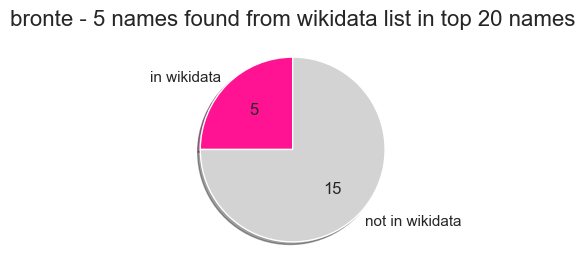

Found from Wikidata: 
    
    ['Bertha Mason', 'Diana Rivers', 'Jane Eyre', 'Mr. Rochester', 'St. John Rivers']

Not from Wikidata:

    ['Adèle', 'Bessie', 'Did', 'Eliza', 'Georgiana', 'God', 'Grace Poole', 'Hannah', 'Helen', 'Louisa', 'Lowood', 'Miss Oliver', 'Miss Temple', 'Mr. Brocklehurst', 'Thornfield']


In [93]:
# Pie chart sizes are notionally relative to the number of characters that were listed in Wikidata:
labels = ['in wikidata', 'not in wikidata']
relative_wikidata_sizes = {'dickens': (3,3), 'carroll': (4, 4), 'alcott': (5, 5), 'bronte': (3,3)}
for author in all_authors:
    data = [top20_tracking[author]['found'], 20 - top20_tracking[author]['found']]
    fig1, ax = plt.subplots(figsize=relative_wikidata_sizes[author])

    ax.pie(x=data, labels=labels, autopct=lambda x: '{:.0f}'.format(x*np.sum(data)/100),
            shadow=True, startangle=90, colors = [author_colors[author], 'lightgrey'])
    plt.title(f'''{author} - {top20_tracking[author]['found']} names found from wikidata list in top 20 names''', \
              fontsize = 16)
    plt.show()
    print(f'''Found from Wikidata: 
    
    {sorted(top20_tracking[author]['found_items'])}

Not from Wikidata:

    {sorted(top20_tracking[author]['other_items'])}''')

# 4. Present quantitative contextual information on characters

At this point we have a fairly rich dataset comprised of:

* Books split by author, chapter, paragraph and sentence (```book_components``` table) which includes:
    * Whole sentences and sentence lemmas
* Author vocabularies and word frequencies (```*_vocab``` tables)
* Raw entities identified per sentence (```book_entities```)
* Final entities extracted (```author_entities```)

This dataset can be used as-is to visualize various aspects of the books, _and_ in addition it can be used as a springboard for generating new insights, for example performing sentiment analysis.

In the first part of this project (Student, 2022) I looked at visualizing information about the books as a whole including:

* How long is each book?
* How many chapters does each book have?
* How are chapter lengths distributed?
* What is the vocabulary size of each book?
* What are the top unique words in each book?

I will now extend those visualizations with the following character-based data:

* __How prominent is each character in terms of mentions?__
* __Are characters a sustained presence in the book or do they come and go?__

And then add to this by performing basic sentiment analysis on the sentences to get a sense of:

* __How might we feel about each character?__

First we need to get each mention per chapter and relate it to its unique key (so that both _Rabbit_ and _White Rabbit_ count as mentions towards the single character _White Rabbit_):

In [94]:
characters_per_chapter = {}
for author in all_authors:
    raw_count_df = processed_books[author][['chapter', 'proper_nouns']].copy()
    raw_count_df = raw_count_df.explode('proper_nouns')
    raw_count_df = raw_count_df[raw_count_df['proper_nouns'].isin(top_20[author]['name'].tolist())]
    raw_count_df = raw_count_df.merge(top_20[author][['name', 'key']], how = 'left', \
                                      left_on = 'proper_nouns', right_on = 'name')
    raw_count_df.drop(columns = ['name'], axis = 1, inplace = True)
    raw_count_df['chapter'] = pd.to_numeric(raw_count_df['chapter'])
    characters_per_chapter[author] = raw_count_df
    
# Check the output is as expected
characters_per_chapter['carroll'].head()

,chapter,proper_nouns,key
0,0,Alice,Alice
1,0,Alice,Alice
2,0,White,Rabbit
3,0,Alice,Alice
4,0,Rabbit,Rabbit


Next we need to count the character mentions per book and per chapter:

In [95]:
character_counts_per_book = {}
character_counts_per_chapter = {}
for author in all_authors:
    character_counts_per_book[author] = pd.DataFrame(characters_per_chapter[author].groupby\
                                             (by = ['key'])['proper_nouns'].count()).reset_index()
    character_counts_per_chapter[author] = pd.DataFrame(characters_per_chapter[author].groupby\
                                            (by = ['chapter', 'key'])['proper_nouns'].count()).reset_index()

# Check the output for character_counts_per_book is as expected
character_counts_per_book['carroll'].head()

,key,proper_nouns
0,Alice,387
1,Bill,13
2,Cat,26
3,Caterpillar,26
4,Come,13


In [96]:
# Check the output for character_counts_per_chapter is as expected
character_counts_per_chapter['carroll'].head()

,chapter,key,proper_nouns
0,0,Alice,28
1,0,Come,1
2,0,Dinah,5
3,0,Rabbit,5
4,1,Alice,25


## 4.1 Character mention frequencies

The below charts can give the reader a good idea of which main characters to expect. The wordcloud format is rather fun, where the frequency distributions give one a much more specific view. One issue to note is that, where narration is in the first person as with __Great Expectations__ and __Jane Eyre__ the most main characters (_Pip_ and _Jane_) are not first in the list! This again highlights the need for coreference resolution where we could determine that 'I' is referring to the narrator and should count as a mention towards that main character.

In [97]:
def create_word_cloud(author, frequency_dist, colormap):
    cloud = WordCloud(background_color='white', max_words=40, colormap = colormap)
    
    # generate word cloud
    cloud.generate_from_frequencies(frequency_dist)
    plt.rcParams['figure.figsize'] = (12, 12)
    # show
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(f'''Top characters in {author}
    ''', fontsize = 16)
    plt.show()


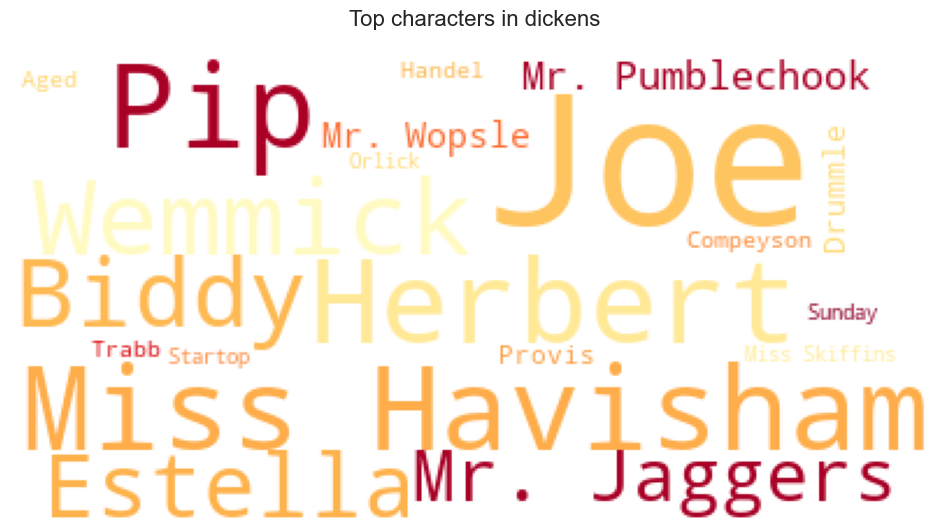

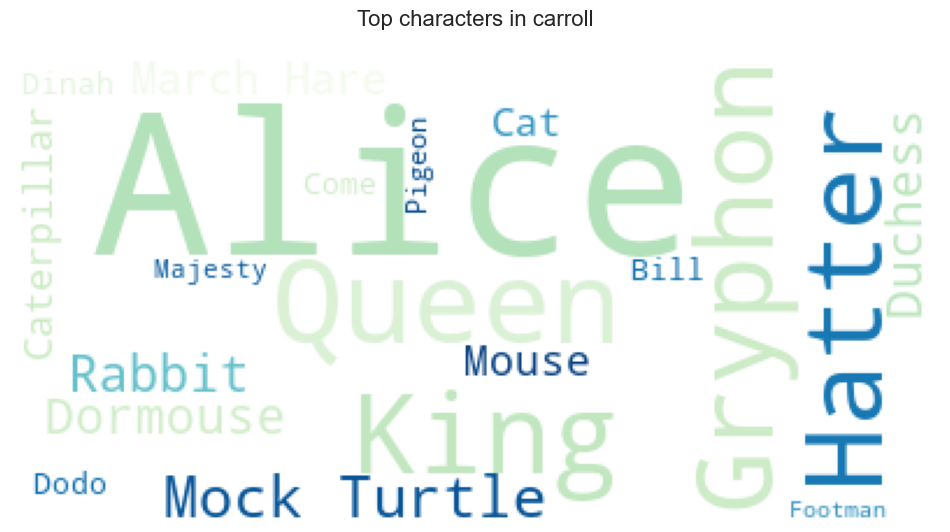

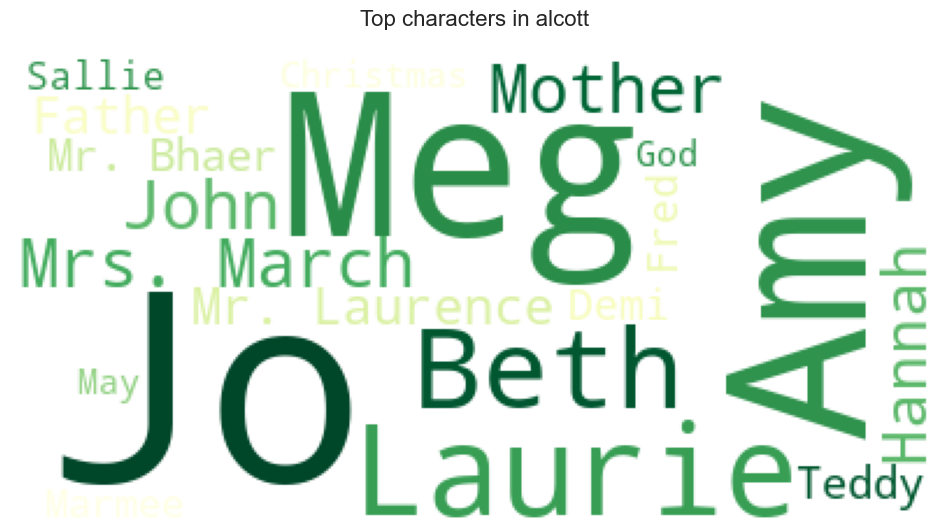

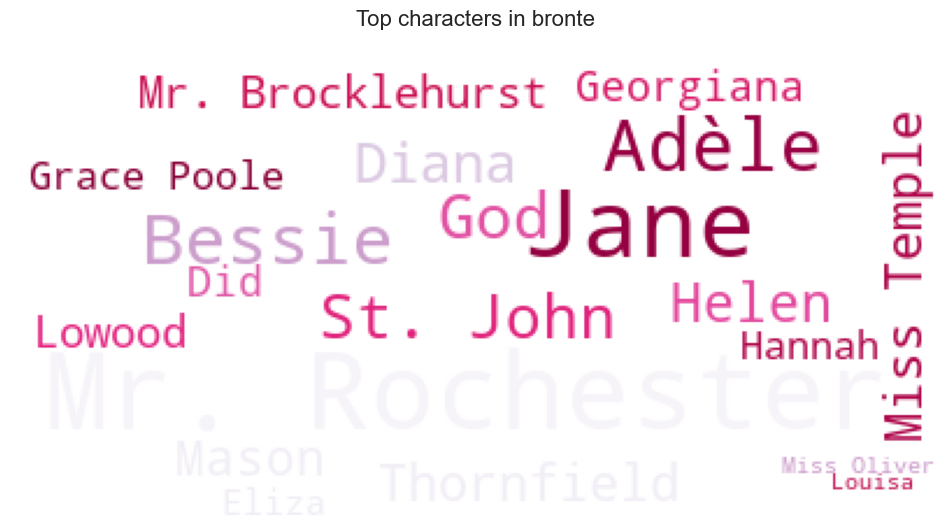

In [98]:
for author in all_authors:
    create_word_cloud(author, dict(character_counts_per_book[author][['key', 'proper_nouns']].values),\
                      author_colormaps[author])

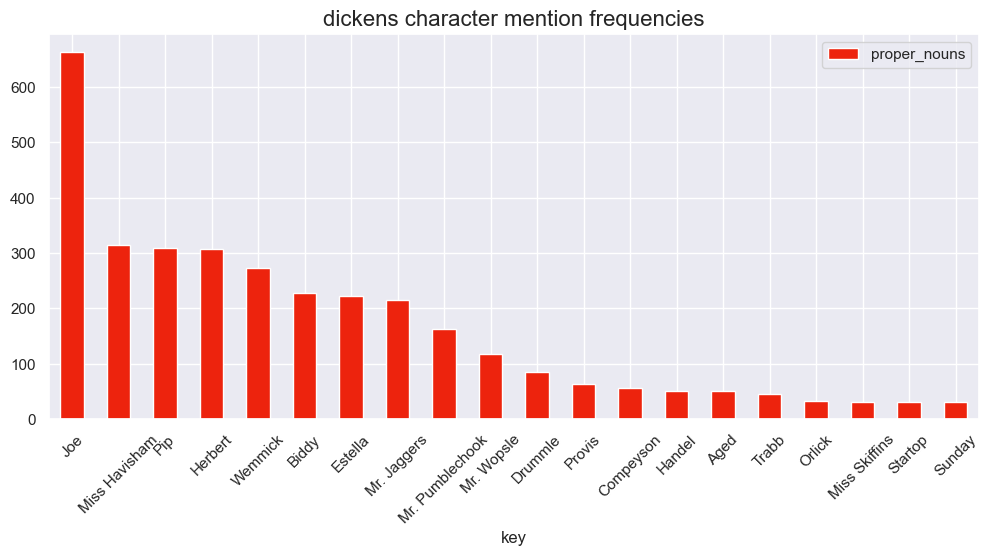

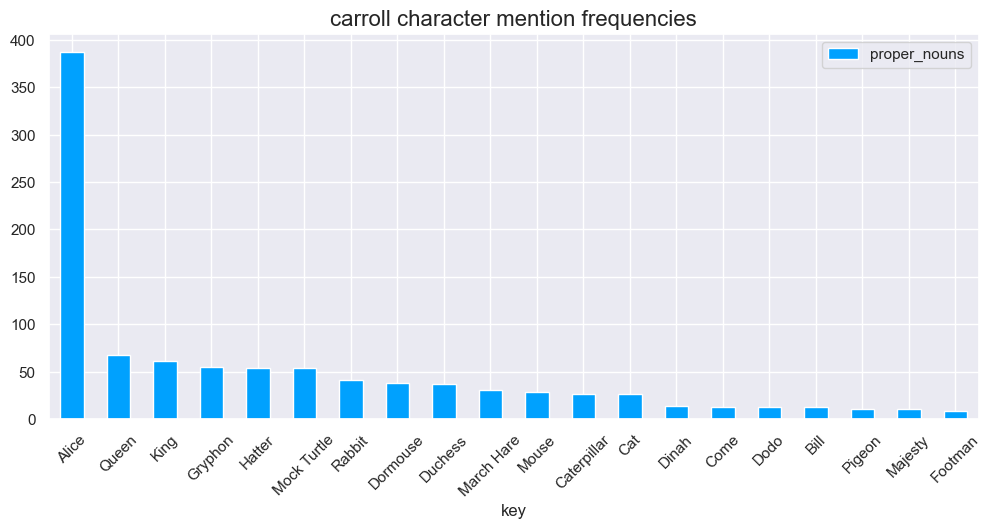

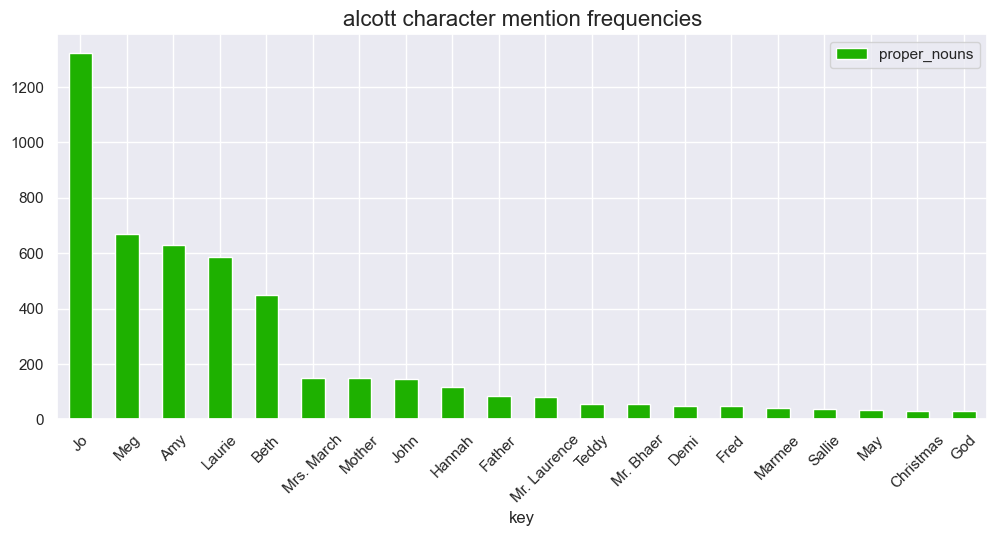

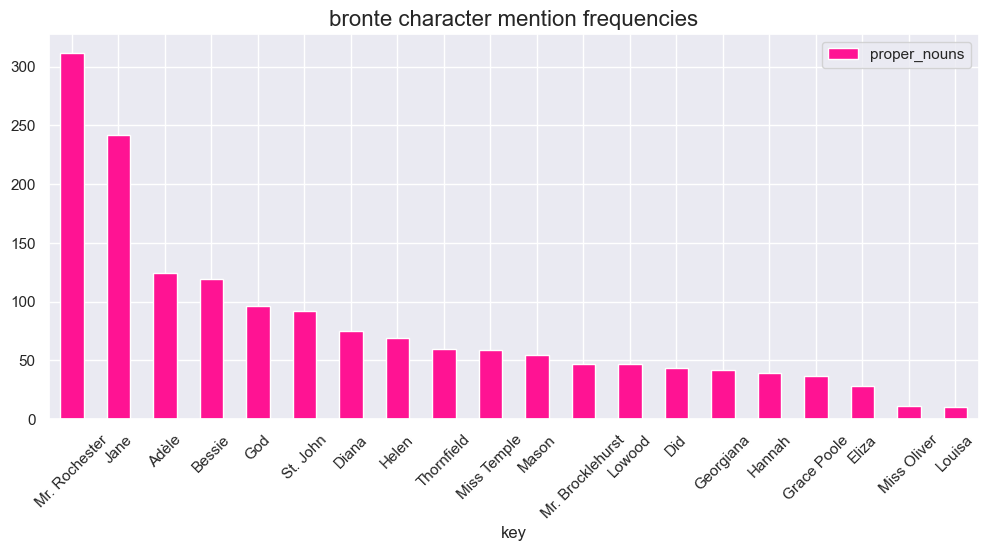

In [99]:
for author in all_authors:
    plt.rcParams['figure.figsize'] = (12, 5)
    character_counts_per_book[author].sort_values('proper_nouns', ascending = False).plot\
        (kind = 'bar', x = 'key', y = 'proper_nouns', color = author_colors[author], rot = 45)
    plt.title(f'''{author} character mention frequencies''', fontsize = 16)
    plt.show()

## 4.2 Character ebb and flow

The below charts can give the reader an idea of which characters are most prominent by chapter. I'll be using a heatmap so this is a transform to get the data into the right shape before constructing that visualization:

In [100]:
character_heatmaps = {}
for author in all_authors:
    heatmap = pd.pivot_table(character_counts_per_chapter[author], index = 'chapter', columns = 'key', \
                             values = 'proper_nouns')
    heatmap.fillna(0, inplace = True)
    character_heatmaps[author] = heatmap

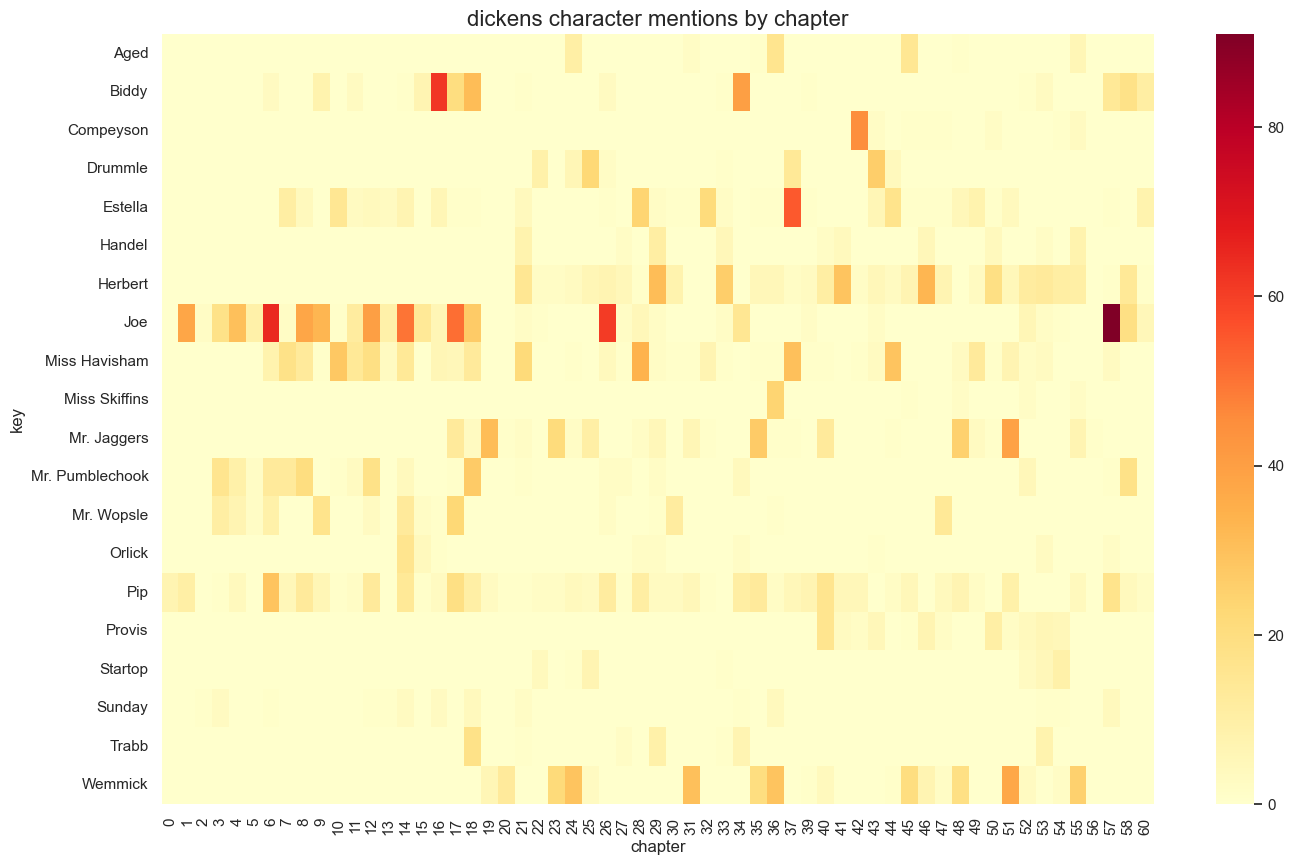

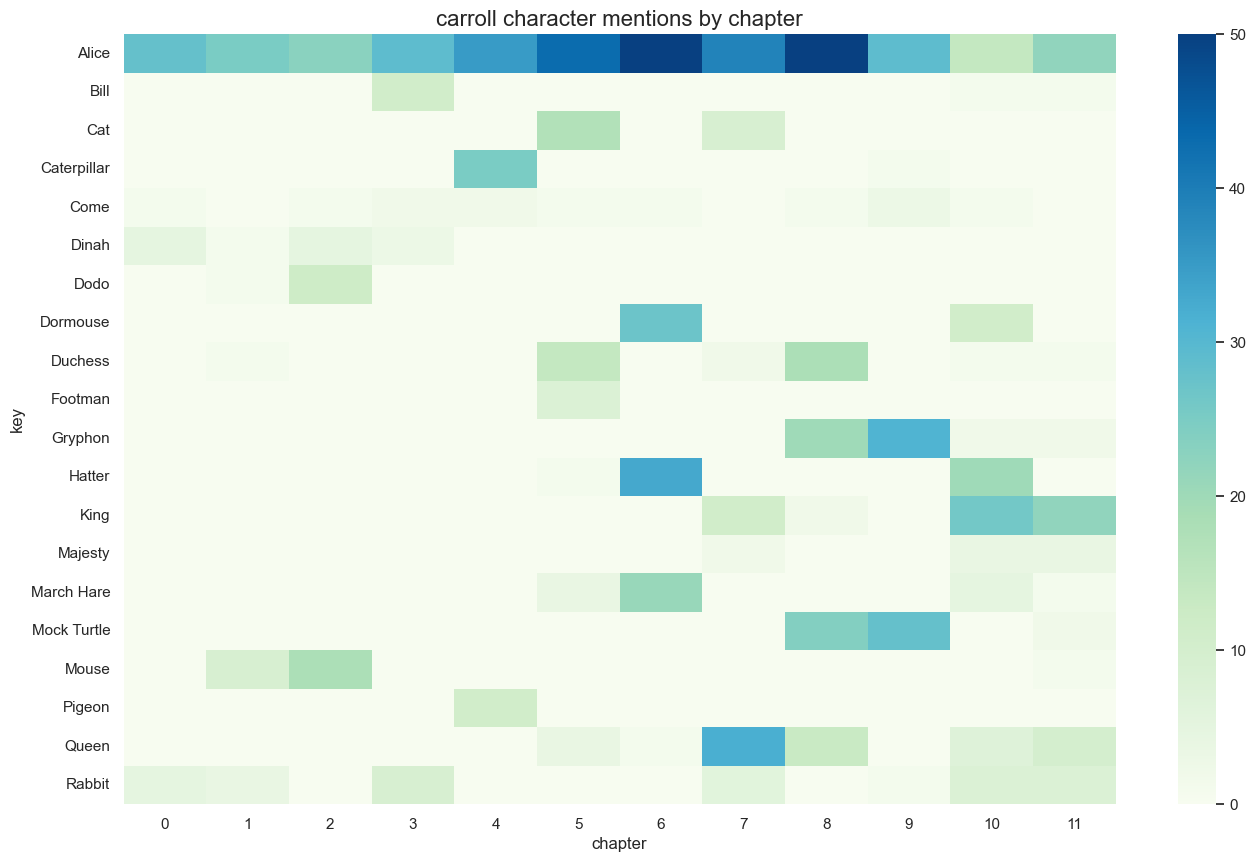

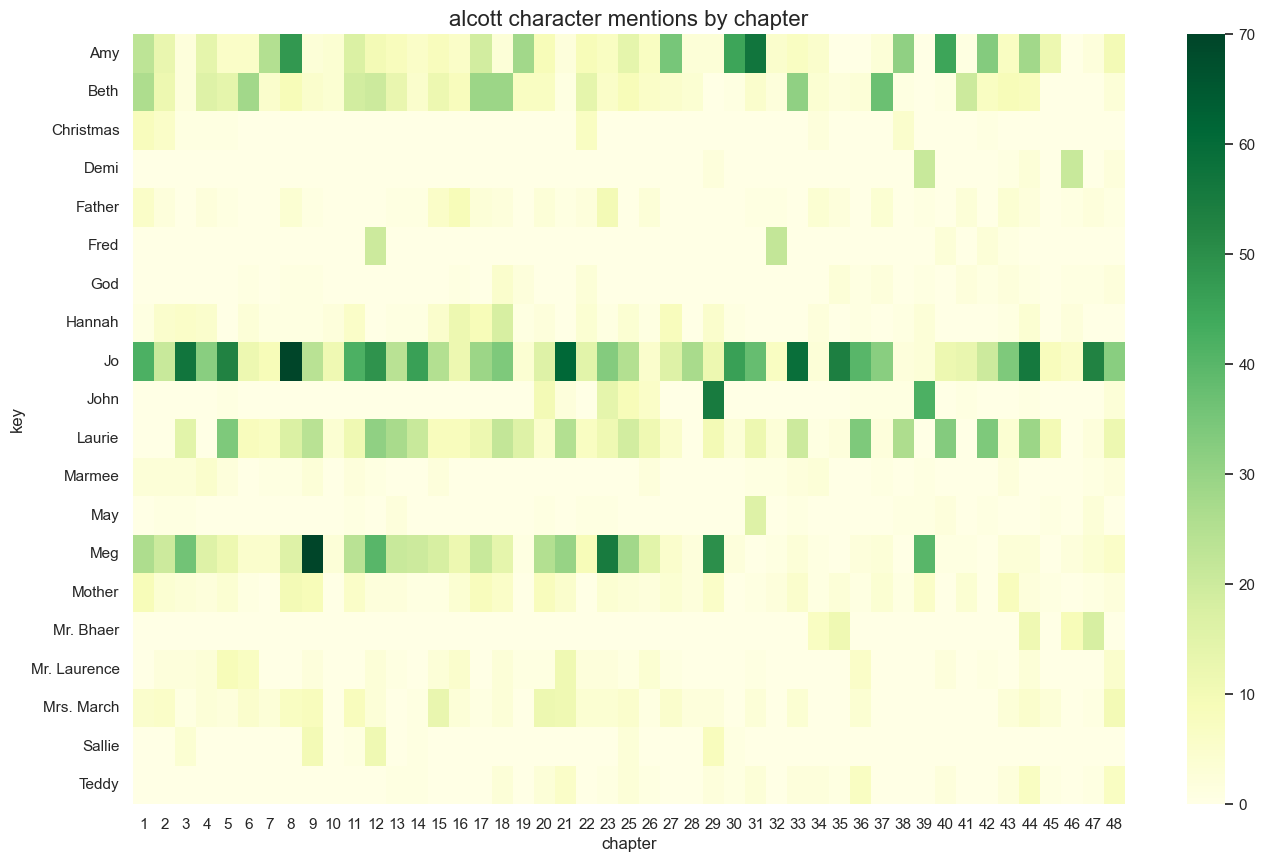

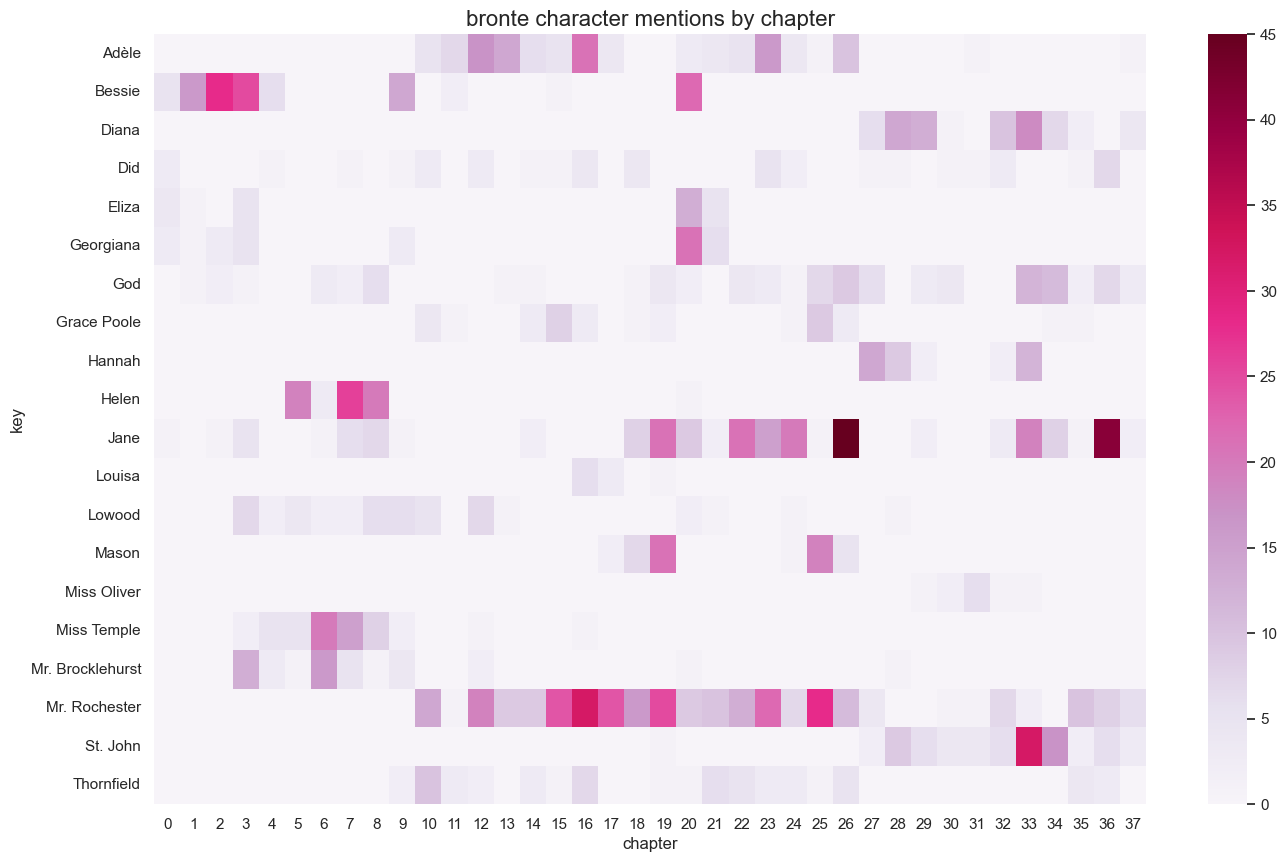

In [101]:
author_colormaps = {'dickens': 'YlOrRd', 'carroll': 'GnBu', 'alcott': 'YlGn', 'bronte': 'PuRd'}
for author in all_authors:
    plt.rcParams['figure.figsize'] = (16, 10)
    sns.heatmap(character_heatmaps[author].transpose(), cmap = author_colormaps[author], )
    plt.title(f'''{author} character mentions by chapter''', fontsize = 16)
    plt.show()

#### How do the character mentions line up?

There are plenty of data points that line up with what we know to be true of the books. Here are some examples:

In ```dickens``` we can quite clearly see that _Joe_ features strongly in the first part of the book, and then disappears (mostly) for a while until the end; this corresponds with an increase in the presence of _Herbert_, _Mr. Jaggers_ and _Wemmick_ who all feature strongly in the London-based part of the book after _Pip_ moves to that city. Again the visualization of _Pip_ should have been stronger - had we accounted for all his first person mentions.

In ```carroll``` the procession of characters is much simpler and therefore much clearer. Alice is strong throughout (this is her story after all). We can also see key groupings, for example, in the seventh chapter (our 6 as we counted from 0!) we see _Alice_, the _March Hare_, the _Hatter_ and _Dormouse_ gathered together for the famous 'Mad Hatters Tea Party'.

In ```alcott``` _Jo_ shines through as the main character. We also see aspects like _Meg_ who is a constant presence in the book until she gets married and moves away, thereafter coming in and out of the narrative more intermittently.

In ```bronte``` we can easily see that one of the main characters _Mr. Rochester_ is only introduced in the 11th chapter. _St. John_, his rival makes a play for Jane in the chapters around 33 - and the switch between the 2 characters is quite clear to see at this point!

## 4.3 Character sentiment analysis

I've selected the NLTK implementation of __vader__ for this section as it is quick and easy to implement. There are many other options that would doubtless yield superior results, however, here I just aim to illustrate how sentiment could be achieved and visualized on a per-character basis. __vader__ uses the sentiment lexicon approach ([Hutto & Gilbert, 2014](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)). 

According to the example usage documentation ([Hutto, 2020](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py)) __vader__ works best at sentence level and it is suggested that multiple sentences can be averaged to arrive at an overall sentiment score. The __compound score__ which I'll be using is in the range between -1 (extremely negative) and +1 (extremely positive).

In [102]:
analyzer = SentimentIntensityAnalyzer()

If we look at a few toy examples, we can see how the __vader__ scores change, depending on words introduced to a sentence:

In [103]:
# It's interesting to notice how the scores change, depending on words introduced to a sentence
test_sentences = ['Alice was feeling bored',
                  'Alice was feeling exceptionally bored',
                  'Alice really hated it when she was feeling bored']
for sentence in test_sentences:
    print(f'''{sentence}
    scores - {analyzer.polarity_scores(sentence)}
    ''')

Alice was feeling bored
    scores - {'neg': 0.375, 'neu': 0.357, 'pos': 0.268, 'compound': -0.1531}
    
Alice was feeling exceptionally bored
    scores - {'neg': 0.347, 'neu': 0.435, 'pos': 0.218, 'compound': -0.2247}
    
Alice really hated it when she was feeling bored
    scores - {'neg': 0.468, 'neu': 0.426, 'pos': 0.106, 'compound': -0.7264}
    


Hutto and Gilbert ([2014](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)) describe the __vader__ algorithm as being _especially  attuned to  microblog-like  contexts._'. This means it's probably not perfect for our purposes: modern writers in informal contexts like blogs and social media often bluntly 'call a spade a spade'. However, the language of our 19th century novels tends to be more restrained and sometimes rather oblique. Looking at a sample of negative sentences from our books we can see that __vader__ doesn't always pick up the negativity:

In [104]:
test_sentences = ['''"So hard, so hard!" moaned Miss Havisham, with her former action.''',
                  '''What do you play, boy?" asked Estella of myself, with the greatest disdain.''',
                  '''Not only that, but I felt convinced that Miss Havisham too would not be understood; 
                  and although she was perfectly incomprehensible to me, I entertained an impression that 
                  there would be something coarse and treacherous in my dragging her as she really was 
                  (to say nothing of Miss Estella) before the contemplation of Mrs. Joe.''']
for sentence in test_sentences:
    print(f'''{sentence}
    scores - {analyzer.polarity_scores(sentence)}
    ''')

"So hard, so hard!" moaned Miss Havisham, with her former action.
    scores - {'neg': 0.409, 'neu': 0.591, 'pos': 0.0, 'compound': -0.5464}
    
What do you play, boy?" asked Estella of myself, with the greatest disdain.
    scores - {'neg': 0.157, 'neu': 0.508, 'pos': 0.335, 'compound': 0.5423}
    
Not only that, but I felt convinced that Miss Havisham too would not be understood; 
                  and although she was perfectly incomprehensible to me, I entertained an impression that 
                  there would be something coarse and treacherous in my dragging her as she really was 
                  (to say nothing of Miss Estella) before the contemplation of Mrs. Joe.
    scores - {'neg': 0.058, 'neu': 0.712, 'pos': 0.231, 'compound': 0.9253}
    


Nonetheless, I'm expecting it to be good enough for illustrative purposes. If pursuing this project, it would be ideal to experiment with other algorithms to compare results.

First we extract our compound sentiment scores for each sentence:

In [105]:
texts_for_sentiment = {}
for author in all_authors:
    raw_text_df = processed_books[author][['chapter', 'paragraph', 'sentence', 'text', 'proper_nouns']].copy()
    raw_text_df['sentiment'] = raw_text_df['text'].apply(lambda x: analyzer.polarity_scores(x))
    raw_text_df = raw_text_df.explode('proper_nouns')
    raw_text_df = raw_text_df.merge(top_20[author][['name', 'key']], how = 'left', left_on='proper_nouns', \
                                    right_on='name')
    raw_text_df.dropna(axis=0, subset=['key'], inplace = True)
    raw_text_df['compound'] = raw_text_df['sentiment'].apply(lambda x: x['compound'])
    raw_text_df['chapter'] = pd.to_numeric(raw_text_df['chapter'])
    texts_for_sentiment[author] = raw_text_df

Next we get an average score per character and per chapter:

In [106]:
compound_sentiment_character_per_book = {}
compound_sentiment_character_per_chapter = {}
for author in all_authors:
    compound_sentiment_character_per_book[author] = pd.DataFrame(texts_for_sentiment[author].groupby\
                                 (by = ['key'])['compound'].mean()).sort_values('compound').reset_index()
    compound_sentiment_character_per_chapter[author] = pd.DataFrame(texts_for_sentiment[author].groupby\
                                (by = ['key', 'chapter'])['compound'].mean()).sort_values('compound').reset_index()

#### Overall sentiment per character

Here we visualize the sentiment scores associated with each character overall (based on the average of the sentiment scores for the sentences in which they are mentioned):

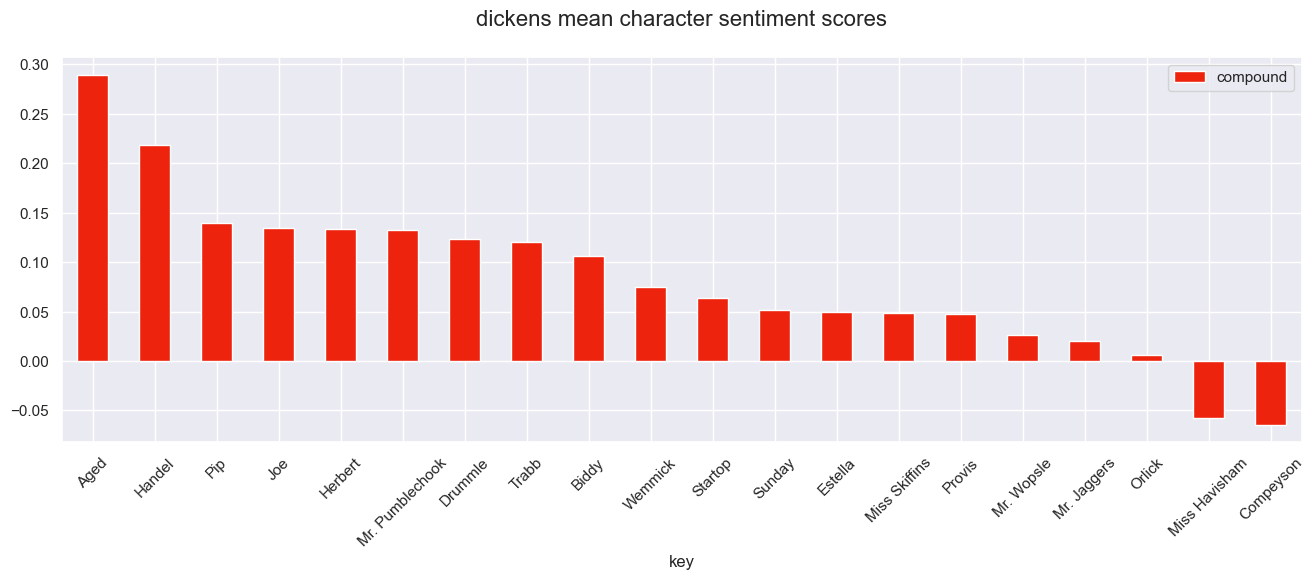

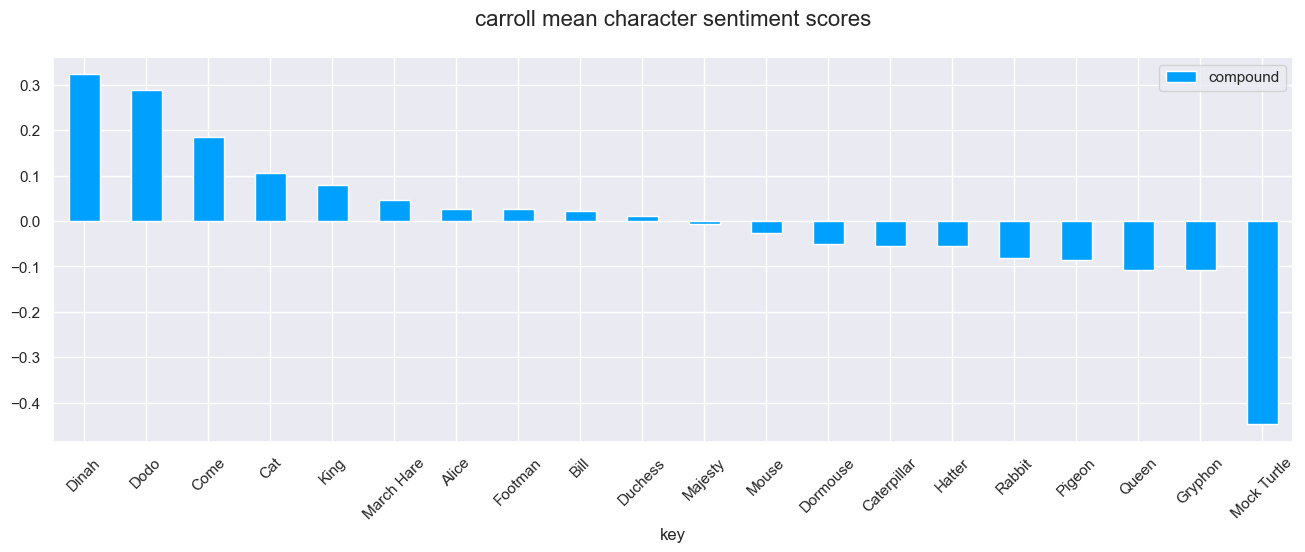

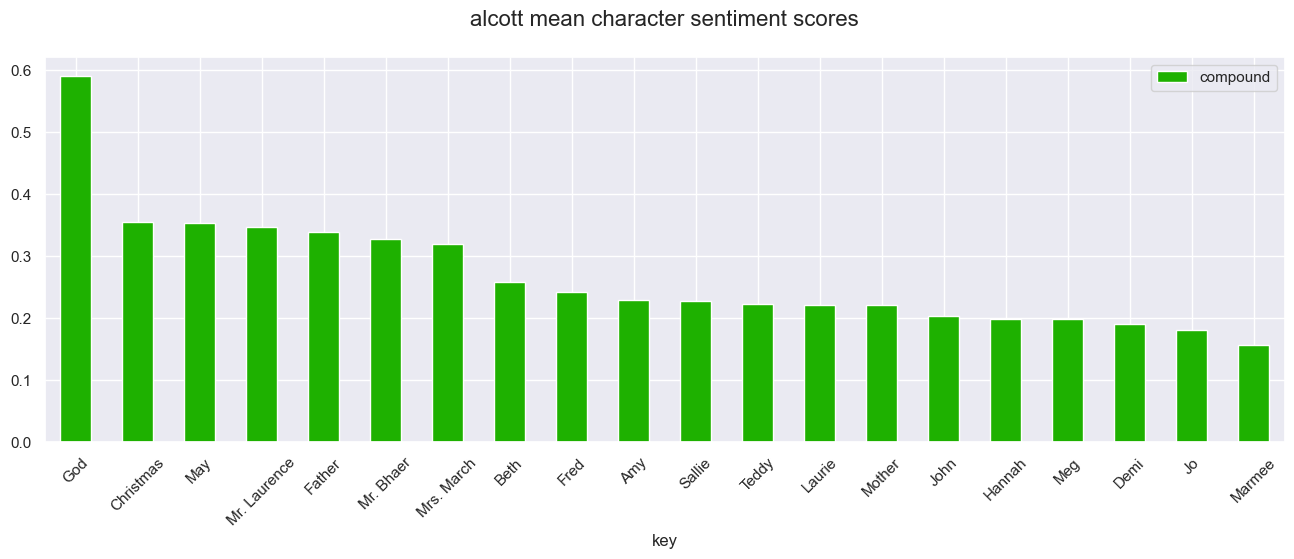

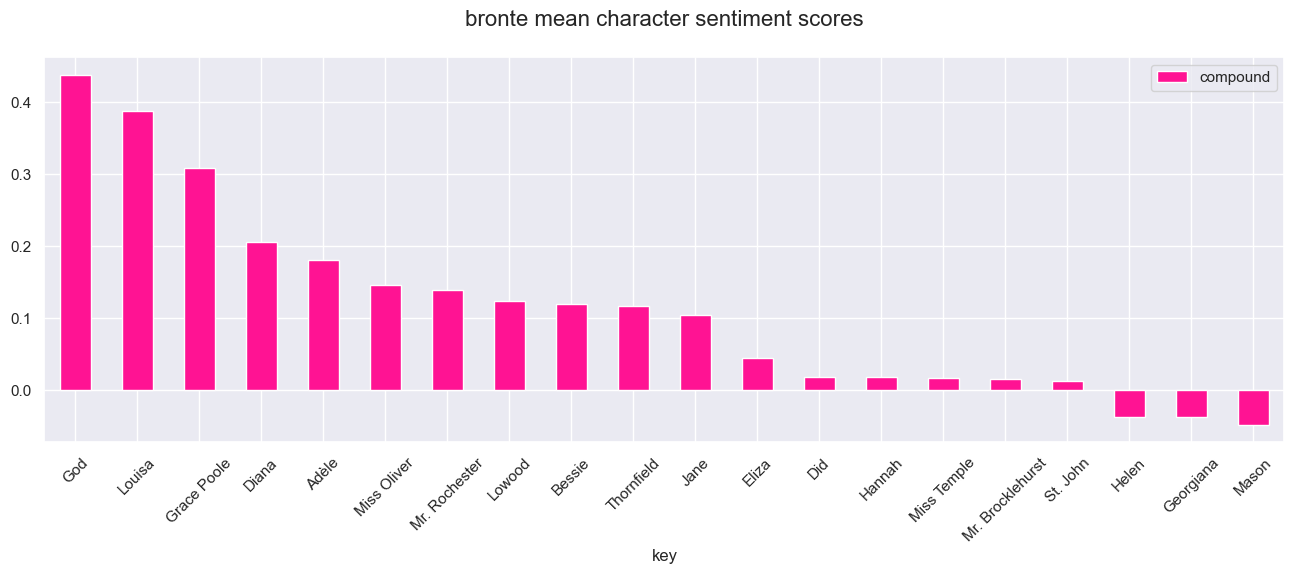

In [107]:
for author in all_authors:
    plt.rcParams['figure.figsize'] = (16, 5)
    compound_sentiment_character_per_book[author].sort_values('compound', ascending = False).plot\
        (kind = 'bar', x = 'key', y = 'compound', color = author_colors[author], rot = 45)
    plt.title(f'''{author} mean character sentiment scores
    ''', fontsize = 16)
    plt.show()

Some observations:

* The first thing that struck me how none of the top 20 characters in ```alcott``` dips below 0 - and this rings true with my own 'feelings' about this book compared to the others: it has a much more positive spin than the others.
* With ```dickens``` the very positive and very negative characters ring true for me, but there are some issues with the middle: _Pumblechook_ and _Drummle_ should be more negatively reflected in the graph than they are, for example. 
* ```carroll``` has the most even spread of positive and negative characters: the extreme positive of Alice's beloved cat _Dinah_ and the extreme negative of the melancholy _Mock Turtle_ make sense.
* Interesting to see how _God_ turned up as the most positive presence in ```bronte```!

Using a fairly simple tool like __vader__ we end up with a reasonable depiction of how we might feel towards each of the characters. With more refined and accurate methods, for example using aspect-based sentiment analysis techniques covered by Madhoushi, et al. ([2019](https://www.researchgate.net/publication/335421201_Aspect-Based_Sentiment_Analysis_Methods_in_Recent_Years)) this kind of visualization would be even more powerful.

#### Character sentiment by chapter

It could also be interesting to compare character sentiment on a chapter-by-chapter basis to see if it fluctuates. 
I'll be using a heatmap again so we need to transform the data to the appropriate shape:

In [108]:
sentiment_heatmaps = {}
for author in all_authors:
    heatmap = pd.pivot_table(compound_sentiment_character_per_chapter[author], index = 'chapter', columns = 'key', values = 'compound')
    heatmap.fillna(0, inplace = True)
    sentiment_heatmaps[author] = heatmap

Here we see dark colors represent very positive sentiment versus lighter colours representing very negative sentiment. 

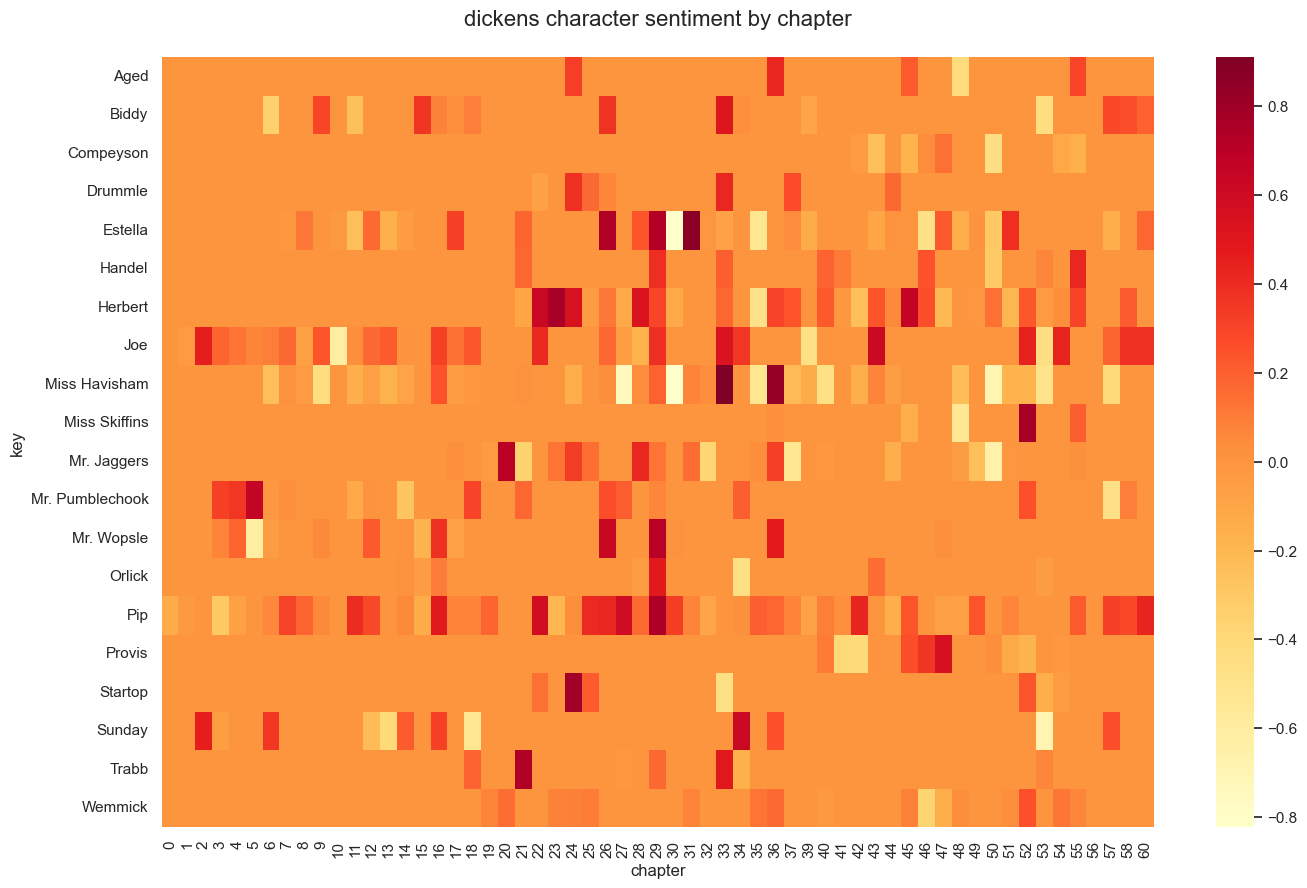

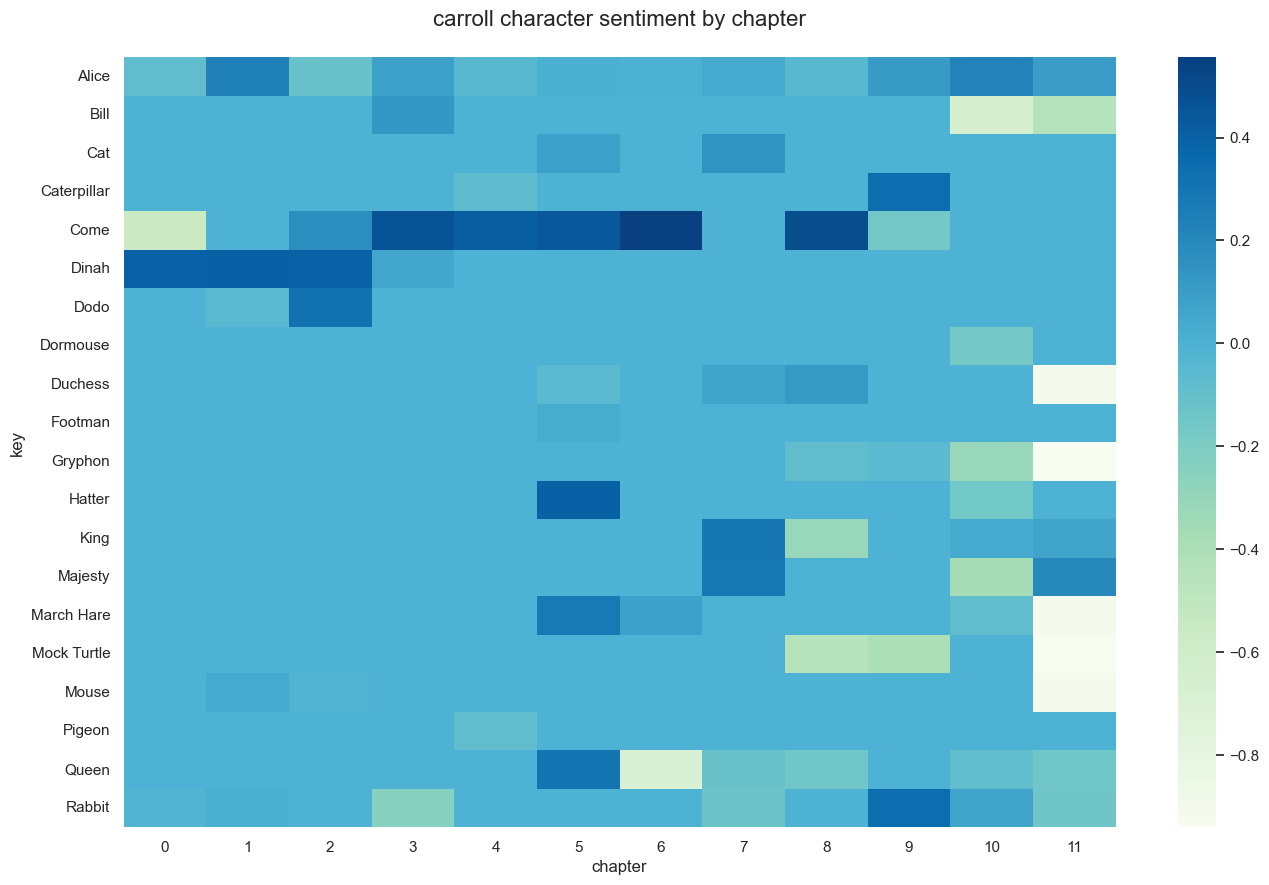

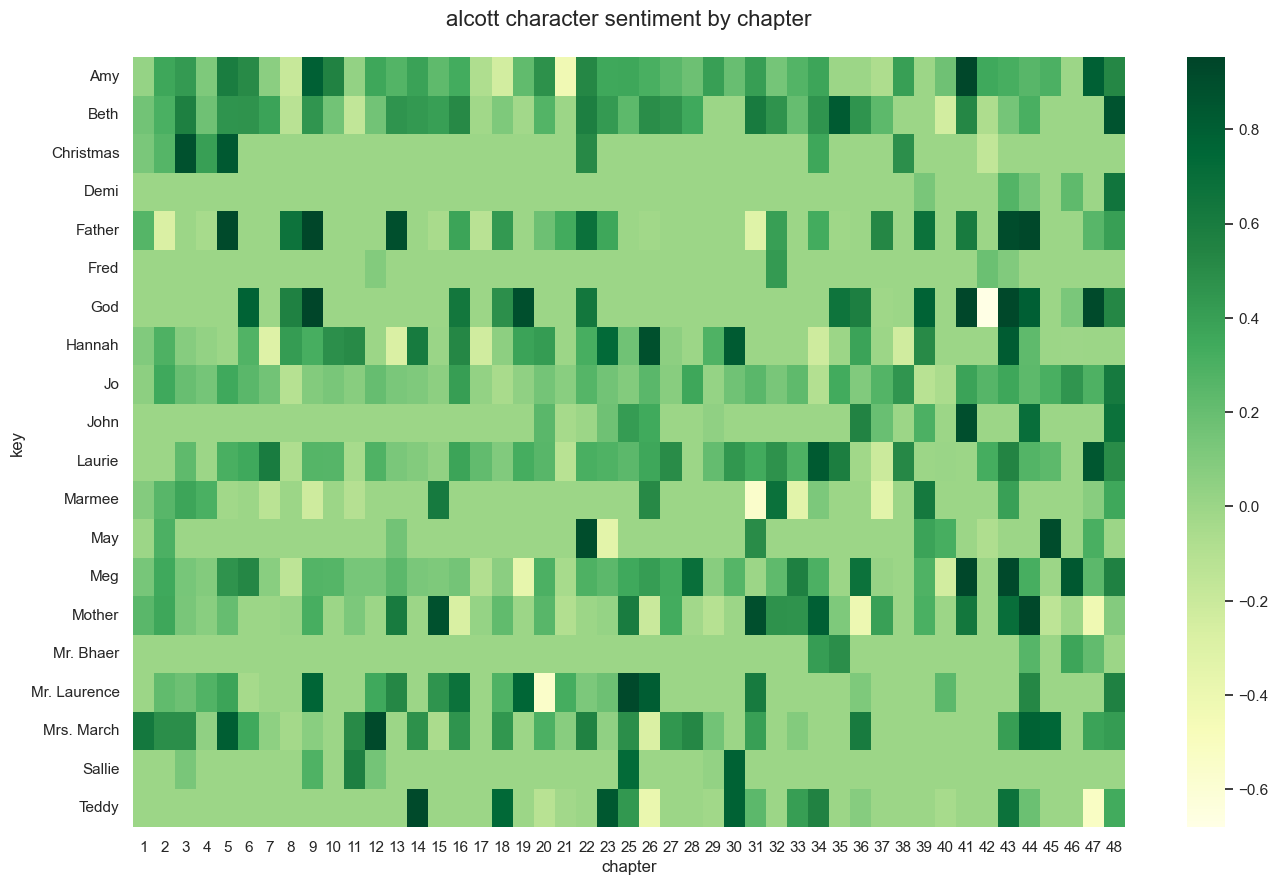

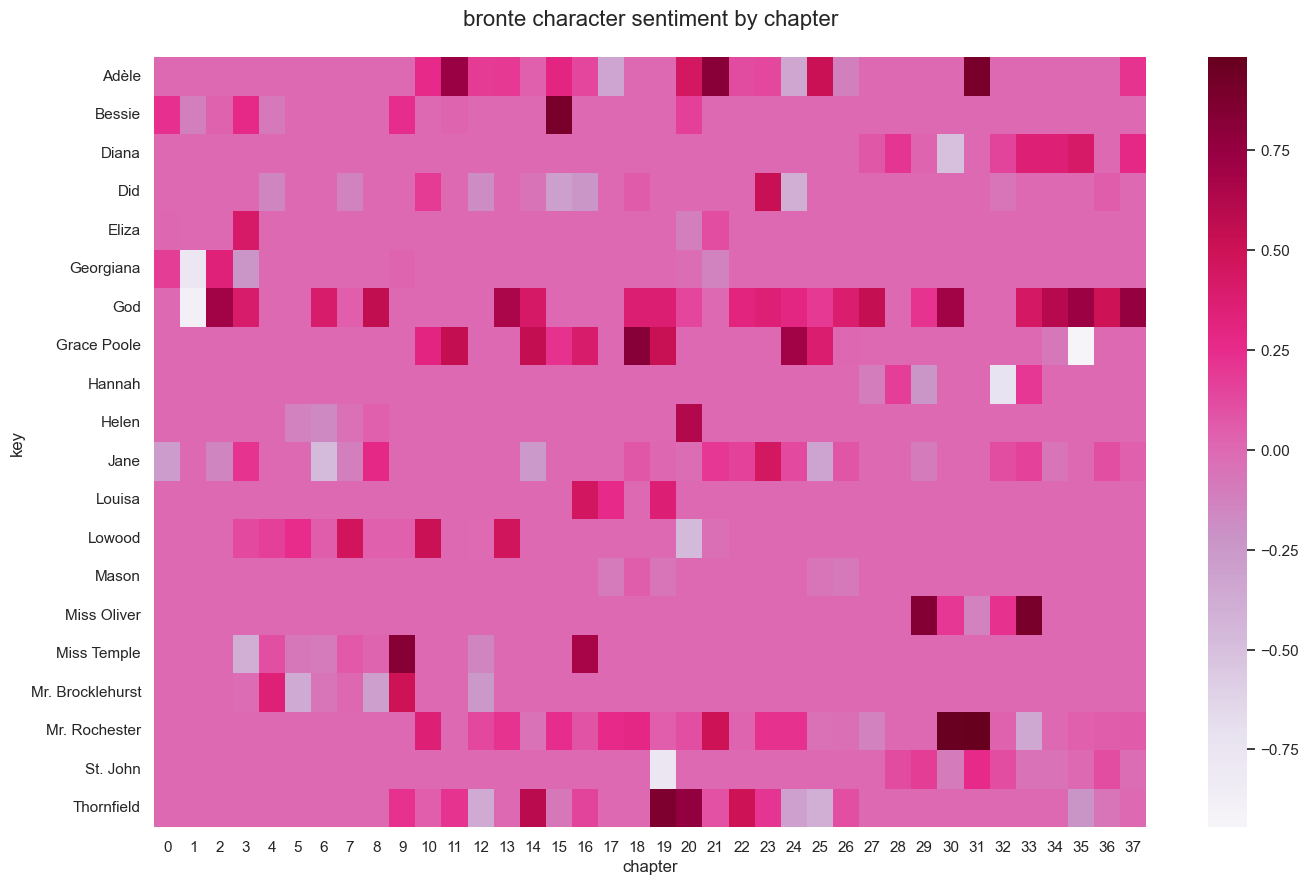

In [109]:
author_colormaps = {'dickens': 'YlOrRd', 'carroll': 'GnBu', 'alcott': 'YlGn', 'bronte': 'PuRd'}
for author in all_authors:
    plt.rcParams['figure.figsize'] = (16, 10)
    sns.heatmap(sentiment_heatmaps[author].transpose(), cmap = author_colormaps[author], )
    plt.title(f'''{author} character sentiment by chapter
    ''', fontsize = 16)
    plt.show()

With ```carroll``` being the simplest book I found it the easiest visualization to interpret: _Dinah_, who is Alice's cat always appears in a positive light - she likes _Dinah_! It's also interesting to notice how much negativity appears in the final chapter: this is the trial scene where, supposedly, it will be determined who stole the tarts. The whole chapter essentially descends into greater levels of chaos as it proceeds, with characters either being aggressive, irritating or irrational - so this negativity we see makes sense.

I was also interested in the very positive, followed by very negative sentiment around _Estella_ towards the middle of _Great Expectations_ so I decided to have a deeper look into these:

#### Delving deeper

We can look at the sentiment __per character by chapter__ to assess what might be going on in more detail:

In [110]:
def plot_sentiment_for_chapter(sentiment_dict, author, chapter):
    plt.rcParams['figure.figsize'] = (16, 5)
    sentiment_dict[author][sentiment_dict[author]['chapter'] == chapter].plot\
        (kind = 'bar', x = 'key', y = 'compound', color = author_colors[author])
    plt.title(f'''Mean sentiment scores by character for {author}, chapter {chapter}
    ''', fontsize = 16)
    plt.show()

Here we see that _Estella_ and _Miss Havisham_ feature at the extreme negative end of the spectrum in the 30th chapter:

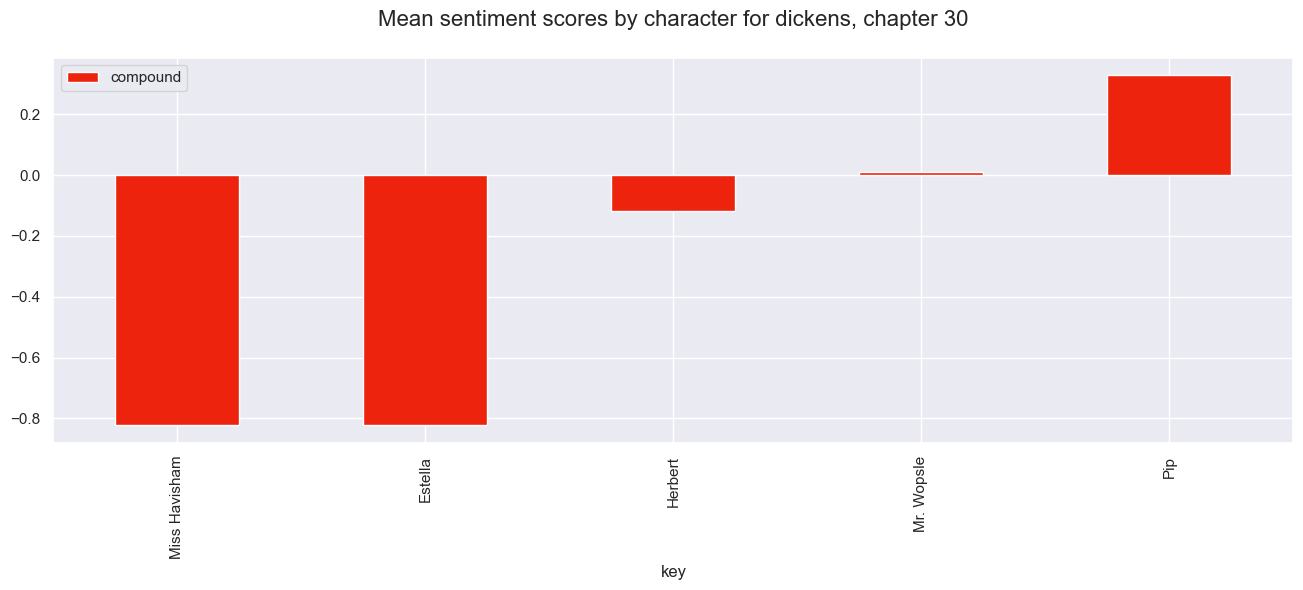

In [111]:
plot_sentiment_for_chapter(compound_sentiment_character_per_chapter, author='dickens', chapter = 30)

This is actually due to only one very negative sentence in which both characters make an appearance:

In [112]:
texts_for_sentiment['dickens'].query('chapter == 30 and key in ["Estella", "Miss Havisham"]')

,chapter,paragraph,sentence,text,proper_nouns,sentiment,name,key,compound
5946,30,34,0,"Miserably I went to bed after all, and miserably thought of Estella, and miserably dreamed that my expectations were all cancelled, and that I had to give my hand in marriage to Herbert's Clara, or play Hamlet to Miss Havisham's Ghost, before twenty thousand people, without knowing twenty words of it.",Estella,"{'neg': 0.246, 'neu': 0.663, 'pos': 0.091, 'compound': -0.8225}",Estella,Estella,-0.8225
5950,30,34,0,"Miserably I went to bed after all, and miserably thought of Estella, and miserably dreamed that my expectations were all cancelled, and that I had to give my hand in marriage to Herbert's Clara, or play Hamlet to Miss Havisham's Ghost, before twenty thousand people, without knowing twenty words of it.",Miss Havisham,"{'neg': 0.246, 'neu': 0.663, 'pos': 0.091, 'compound': -0.8225}",Miss Havisham,Miss Havisham,-0.8225


Here we see that _Estella_ is at the extreme positive end of the spectrum in the 31st chapter:

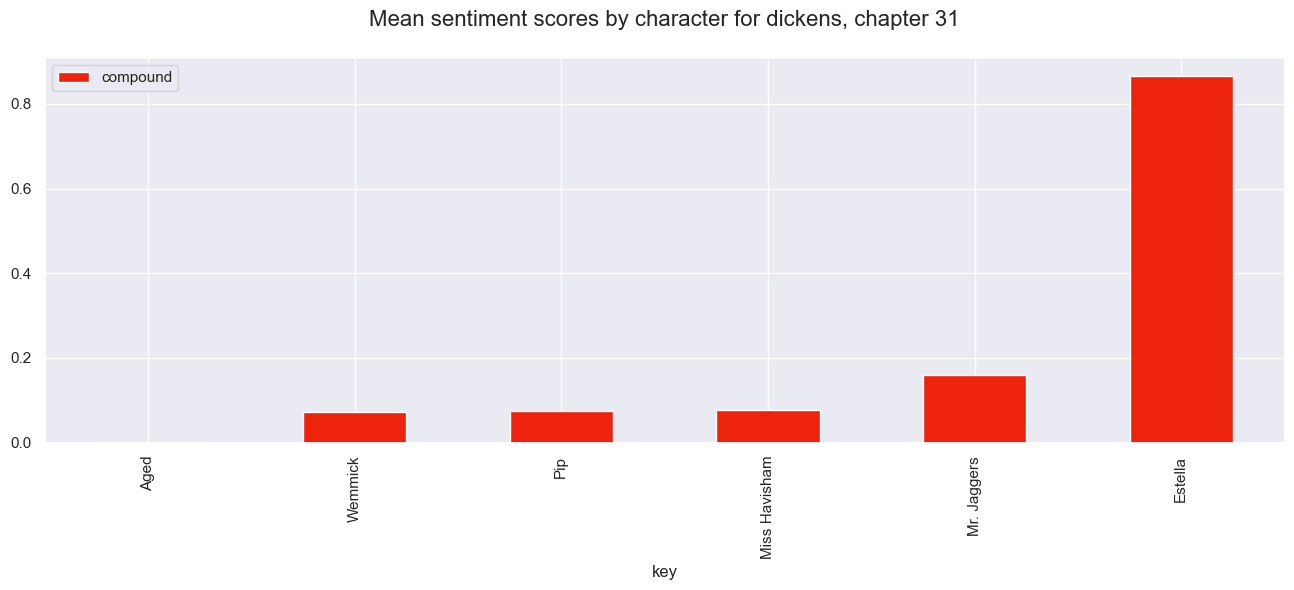

In [113]:
plot_sentiment_for_chapter(compound_sentiment_character_per_chapter, author='dickens', chapter = 31)

Again this is just due to one sentence:

In [114]:
texts_for_sentiment['dickens'].query('chapter == 31 and key == "Estella"')

,chapter,paragraph,sentence,text,proper_nouns,sentiment,name,key,compound
6087,31,44,2,"While my mind was thus engaged, I thought of the beautiful young Estella, proud and refined, coming towards me, and I thought with absolute abhorrence of the contrast between the jail and her.",Estella,"{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.8658}",Estella,Estella,0.8658


This leads us on to considering whether to smooth sentiment based on frequency... but at this point I will draw a line under my investigations dear reader! It's time to take stock of what we've achieved and leave you with a list of suggestions for continued exploration.

# 5. Conclusion

## 5.1 Outcomes

The project has demonstrated _reasonable_ success in extracting the main characters from novels, including the previously unseen novel __Jane Eyre__. _Precision_ ('of all the characters we identified in the Top 20, how many are valid?') and _recall_ ('of the characters that we should have identified, how many did we get?') were both surprisingly high:

__Great Expectations__:

```Precision: 0.93     Recall: 1.0```

__Alice's Adventures in Wonderland__:

```Precision: 0.90     Recall: 0.95```

__Little Women__

```Precision: 0.78     Recall: 0.48```

__Jane Eyre__:

```Precision: 0.83     Recall: 1.0```

Recall was clearly influenced by the variable number of characters listed by our 'source of truth' Wikidata. Nonetheless, the _majority_ of characters in the Top 20 were valid and made sense.

Using proper nouns as the main method of identifying character names worked well to ensure we got the full name in most cases. Loosely 'ensembling' this with the results of the more conventional named entity recognition processes helped to reduce some of the noise in the proper nouns (which did not only include persons but also other types of entities). Leveraging the expected long-tailed distribution of characters ensured that we pruned off more of the noisy 'non-characters' as well as minor and relatively unimportant characters. Grouping names worked to the extent that we could identify closely-related names like _Pip_ and _Mr. Pip_, but was less than perfect when it came to more complex scenarios like families where multiple characters all share the same surname.

## 5.2 Suggested improvements

If I were to continue further with a project like this I would look at the following potential improvement areas for character identification:

#### Evaluation data source

Wikidata was convenient but not consistent or comprehensive. Vala, et al.([2015](https://aclanthology.org/D15-1088.pdf)) made use of [Sparknotes](https://www.sparknotes.com) character lists and noted a similar type of problem. They ended up creating an annotated corpus of 58 books and this data is apparently available on request: if so it would be a very useful corpus to use in further experiments.

#### Improved data cleaning measures

There were some edge cases like 'Which' and 'Come' and 'Did' that were erroneously included in our results. I would certainly like to investigate the root causes of these edge cases in order to formulate a strategy to resolve them. 

#### Use of gazetteers

As we saw, __WordNet__ does not contain comprehensive lists of place names. Assembling information from more detailed gazetteers for countries of interest would be a more robust method of ensuring place names are reliably removed from consideration.

#### Include additional entities to be removed

There are some quick wins to be had like checking for days of the week and months of the year and removing them.

#### Improved grouping of names

Using first name / last name logic it would have been possible to extract improved groupings of names where there was confusion. For example with the _Pockets_ in ```dickens``` we ended up with 8 alternative names involving _Pocket_ and were forced to just take the one with the most mentions (_Herbert_) and set the others aside as 'uncertain'. However, with a little more processing it would be quite feasible to join _Herbert_ and _Herbert Pocket_, _Sarah_ and _Sarah Pocket_, knowing as we do that _Pocket_, which always occurs last, must be the surname.

#### Coreference resolution

To really get quality results from such a project, especially when it comes to the frequency of mentions of each person, coreference resolution would be an essential step. This technique enables us to determine who is being talked about, especially when it comes to the use of pronouns ([Jurafsky & Martin, 2021](https://web.stanford.edu/~jurafsky/slp3/21.pdf)). It would help us to know that 'she' in the following sentence refers to _Alice_: _Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it..._ This kind of technique would help us to identify more mentions of characters where a book is written in the first person. It could also help us to understand aliases, nicknames, family names and formal names and their relationships to obtain better quality name groupings. It seems, however that this would be an area requiring some further research, given that even the latest BookNLP model also did not resolve aliases as desired.

#### Alternative sentiment analysis techniques

We have the sentence lemmas stored in our database already which would make it very easy to look at Naïve Bayes as an alternative for sentiment analysis ([Jurafsky & Martin, 2021](https://web.stanford.edu/~jurafsky/slp3/4.pdf)). And as a further potential refinement in this space we could explore aspect-based sentiment analysis ([Madhoushi, et al. 2019](https://www.researchgate.net/publication/335421201_Aspect-Based_Sentiment_Analysis_Methods_in_Recent_Years)) where sentiment is related to the subject in the sentence it pertains to.

## 5.3 A few final personal notes

Given that I aimed to use what I know (simple programming techniques!) to see how far I could get with a project like this, I'm satisfied with the outcomes. But I'm very conscious that to really progress research in this domain one would ideally want to try to build and improve upon the most _recent_ research in the field. For instance, Brahman, et al. ([2021](https://arxiv.org/pdf/2109.05438.pdf)) recently published a fascinating paper on this subject  entitled _“Let Your Characters Tell Their Story”:
A Dataset for Character-Centric Narrative Understanding_. They not only worked on identifying characters but also generating character summaries. Their approach leveraged the power of the latest transformer models like BERT and RoBERTa, and additionally included evaluation against multiple data sources, as well as manual evaluation by readers. This is a whole other level! 

Simple though the project was, I rather enjoyed being able to explore the characters and their properties through this quantitative lens: I found myself thinking about the books and their characters from new perspectives. In that sense I believe such outputs could be useful to a human literary analyst: asking new questions is a valuable exercise in most endeavours.